# 1. BTC/USD Dataset (Data split 7:3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df.set_index('Date',inplace=True)
df = df[['Price']]

In [3]:
train_size = int(0.7 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size:]

In [4]:
from statsmodels.tsa.stattools import adfuller

In [5]:
def test_stationarity(variable):
    result=adfuller(variable)
    labels = ['t-statistics', 'p-value', 'lags_used', 'number of observations used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [6]:
test_stationarity(train_data['Price'])

t-statistics : -1.494960941240968
p-value : 0.536002600115062
lags_used : 12
number of observations used : 1331
Data is non-stationary 


<Axes: xlabel='Date', ylabel='Price'>

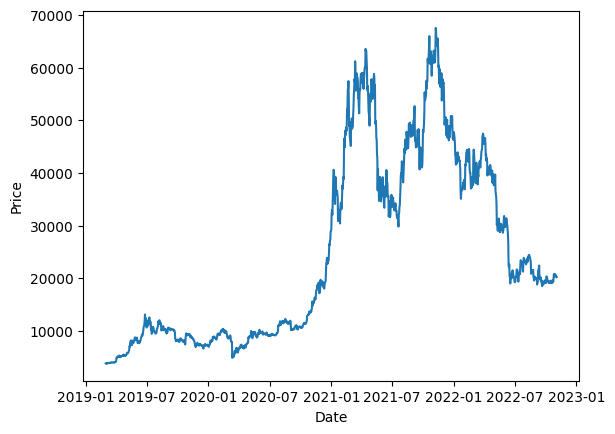

In [7]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Price'])

In [8]:
train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\220069074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)


In [9]:
train_data['Seasonal First Difference']=train_data['Price']-train_data['Price'].shift(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\140462889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Seasonal First Difference']=train_data['Price']-train_data['Price'].shift(30)


In [10]:
test_stationarity(train_data['First Difference'].dropna())

t-statistics : -10.45820391229056
p-value : 1.3808641939967768e-18
lags_used : 11
number of observations used : 1331
Data is stationary


<Axes: xlabel='Date', ylabel='First Difference'>

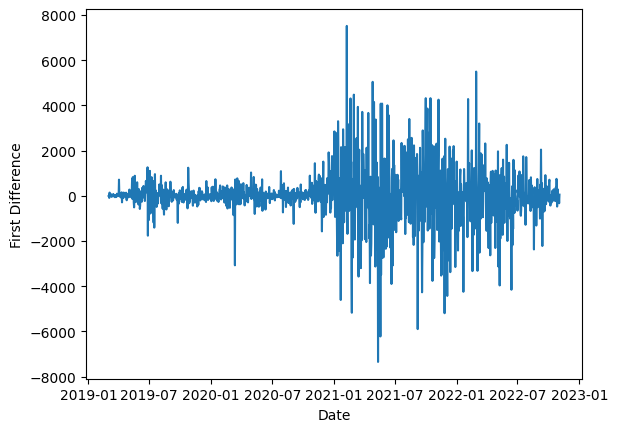

In [11]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['First Difference'])

In [12]:
test_stationarity(train_data['Seasonal First Difference'].dropna())

t-statistics : -4.793659022403242
p-value : 5.5925493859979594e-05
lags_used : 11
number of observations used : 1302
Data is stationary


<Axes: xlabel='Date', ylabel='Seasonal First Difference'>

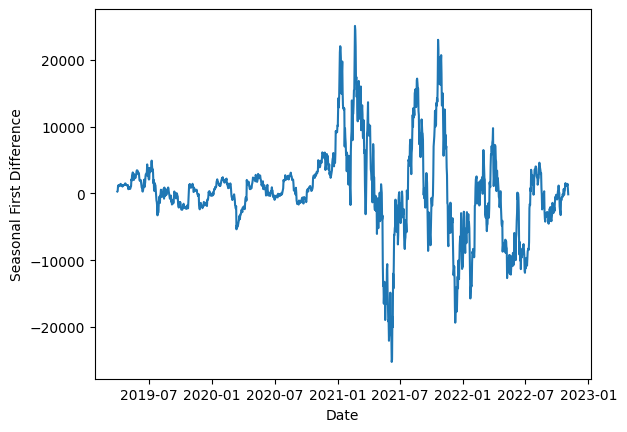

In [13]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Seasonal First Difference'])

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

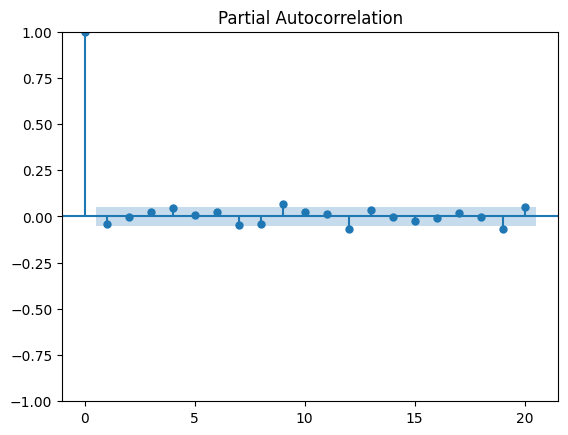

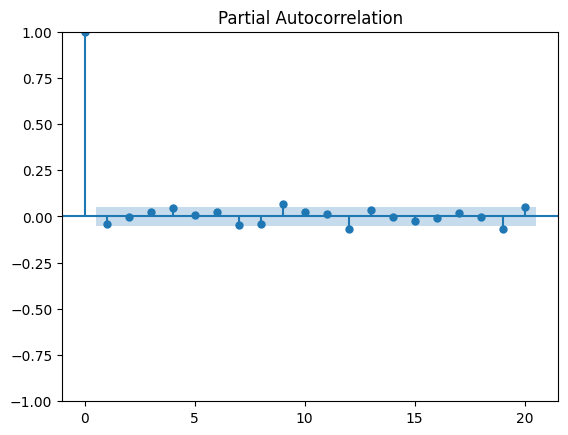

In [15]:
plot_pacf(train_data['First Difference'].dropna(),lags=20)

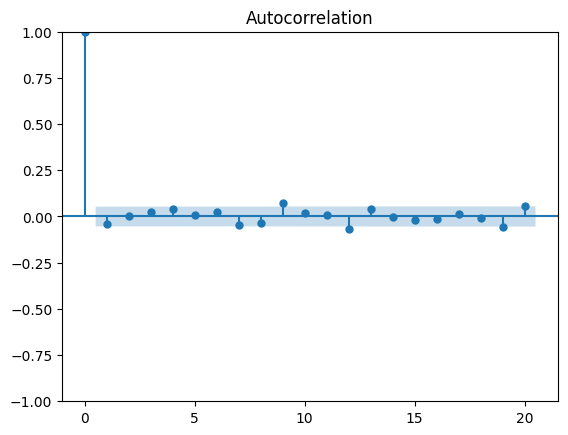

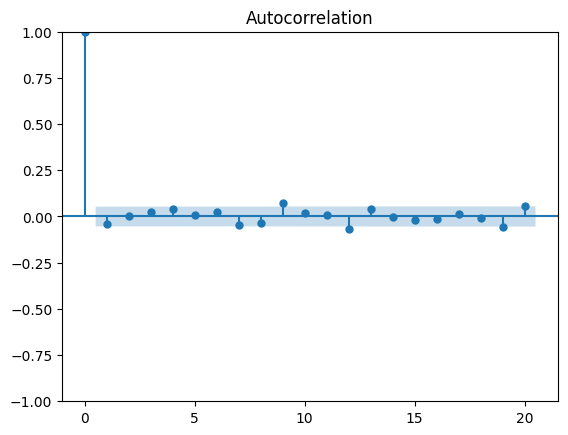

In [16]:
plot_acf(train_data['First Difference'].dropna(),lags=20)

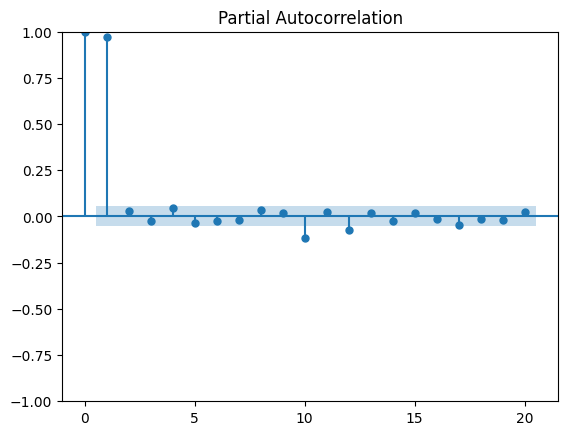

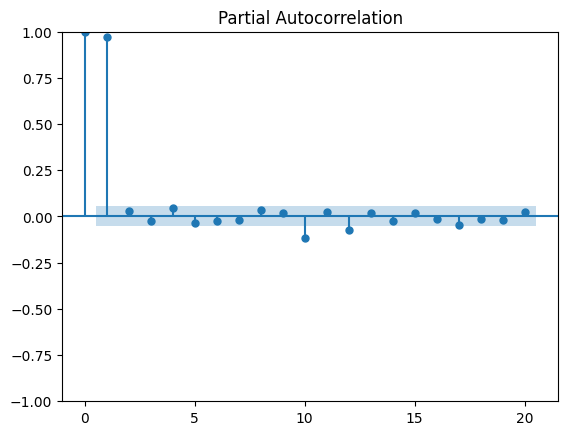

In [17]:
plot_pacf(train_data['Seasonal First Difference'].dropna(),lags=20)

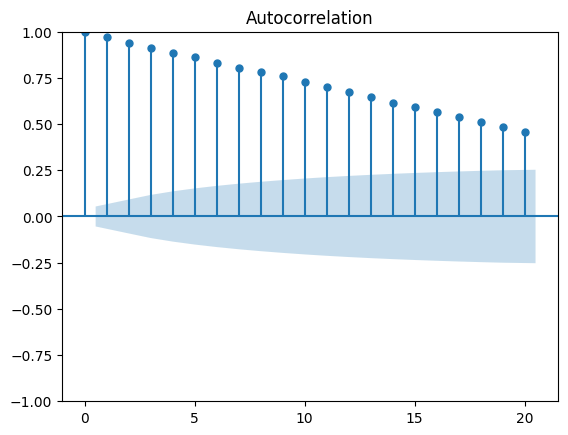

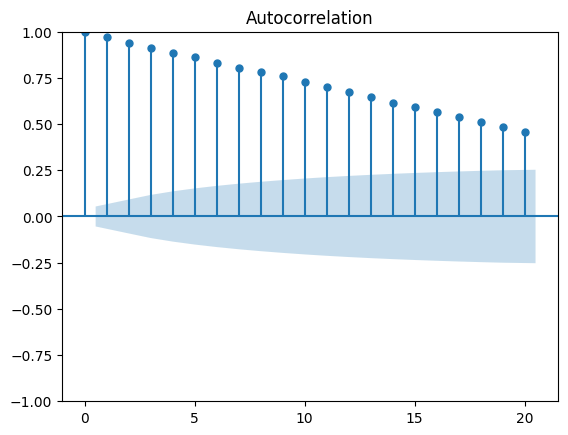

In [18]:
plot_acf(train_data['Seasonal First Difference'].dropna(),lags=20)

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [20]:
model = SARIMAX (train_data['Price'], order = (1,1,1), seasonal_order = (1,1,1,30))
model_fit = model.fit()

C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [21]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 1344
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood              -11178.242
Date:                            Wed, 05 Jun 2024   AIC                          22366.485
Time:                                    08:36:21   BIC                          22392.385
Sample:                                03-01-2019   HQIC                         22376.198
                                     - 11-03-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9986      0.444      2.250      0.024       0.129       1.868
ma.L1         -0.9985      0.417     -2.395      0.017      -1.816      -0.181
ar.S.L30       0.0150      0.023      0.653      0.514      -0.030       0.060
ma.S.L30      -0.9996      0.035    -28.467      0.000      -1.068      -0.931
sigma2       1.35e+06   3.61e-08   3.74e+13      0.000    1.35e+06    1.35e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.53   Jarque-Bera (JB):              2525.60
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):              13.31   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+30. Standard errors may be unstable.
"""

In [22]:
test_prediction = model_fit.forecast(steps=len(test_data))
frame = {'Price':test_prediction[0:]}
test_prediction_df = pd.DataFrame(frame)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test = np.array(test_data['Price'])
y_pred = np.array(test_prediction_df['Price'])

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 29.80882945377768
RMSE: 18939.08405273162
MAE: 13272.137221456083


In [25]:
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90)

In [27]:
future_prediction = model_fit.forecast(steps=len(test_data)+90)
frame = {'Price':future_prediction[0:]}
future_prediction_df = pd.DataFrame(frame)

In [30]:
next60days_df = future_prediction_df[-90:]
next60days_df = next60days_df[:60]
next60days_index = future_index[-90:]
next60days_index = next60days_index[:60]

next30days_df = future_prediction_df[-90:]
next30days_df = next30days_df[:30]
next30days_index = future_index[-90:]
next30days_index = next30days_index[:30]

Text(0, 0.5, 'Price')

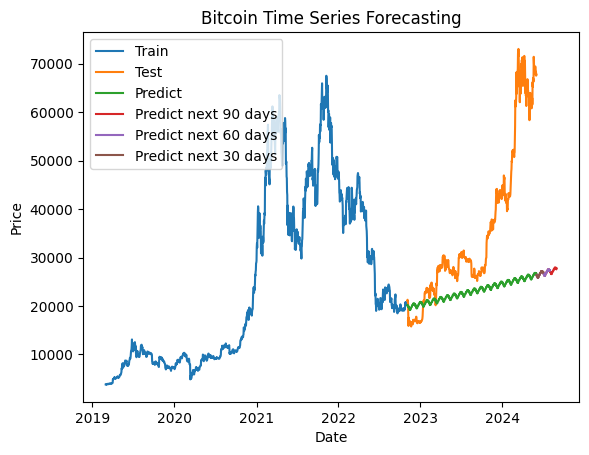

In [31]:
sns.lineplot(data=train_data, x=train_data.index, y=train_data['Price'],label='Train')
sns.lineplot(data=test_data, x=test_data.index, y=test_data['Price'],label='Test')
sns.lineplot(data=test_data, x=test_data.index, y=test_prediction,label='Predict')
sns.lineplot(data=future_prediction_df[-90:], x=future_index[:90], y=future_prediction_df['Price'][-90:],label='Predict next 90 days')
sns.lineplot(data=next60days_df, x=next60days_index, y=next60days_df['Price'],label='Predict next 60 days')
sns.lineplot(data=next30days_df, x=next30days_index, y=next30days_df['Price'],label='Predict next 30 days')
plt.title('Bitcoin Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')

# 2. ETH/USD Dataset (Data split 7:3)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df.set_index('Date',inplace=True)
df = df[['Price']]

In [35]:
train_size = int(0.7 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size:]

In [36]:
from statsmodels.tsa.stattools import adfuller

In [37]:
def test_stationarity(variable):
    result=adfuller(variable)
    labels = ['t-statistics', 'p-value', 'lags_used', 'number of observations used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [38]:
test_stationarity(train_data['Price'])

t-statistics : -1.3767031021035137
p-value : 0.5933925920323656
lags_used : 17
number of observations used : 1326
Data is non-stationary 


<Axes: xlabel='Date', ylabel='Price'>

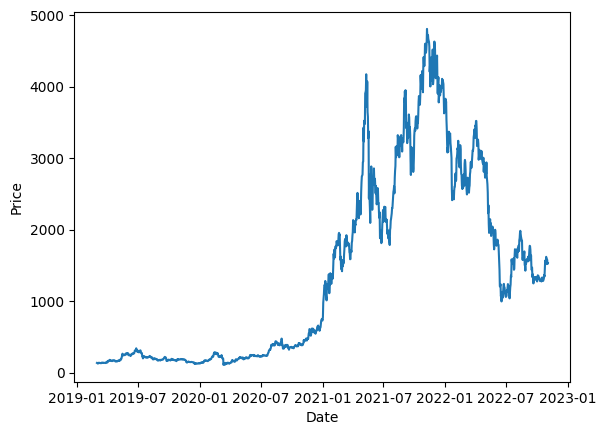

In [39]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Price'])

In [40]:
train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\220069074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)


In [41]:
train_data['Seasonal First Difference']=train_data['Price']-train_data['Price'].shift(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\140462889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Seasonal First Difference']=train_data['Price']-train_data['Price'].shift(30)


In [42]:
test_stationarity(train_data['First Difference'].dropna())

t-statistics : -9.065563577369492
p-value : 4.442522869909455e-15
lags_used : 16
number of observations used : 1326
Data is stationary


<Axes: xlabel='Date', ylabel='First Difference'>

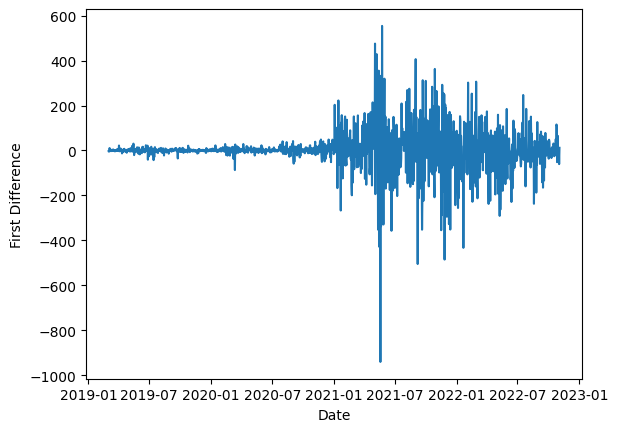

In [43]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['First Difference'])

In [44]:
test_stationarity(train_data['Seasonal First Difference'].dropna())

t-statistics : -4.642075095693221
p-value : 0.00010796753422393281
lags_used : 6
number of observations used : 1307
Data is stationary


<Axes: xlabel='Date', ylabel='Seasonal First Difference'>

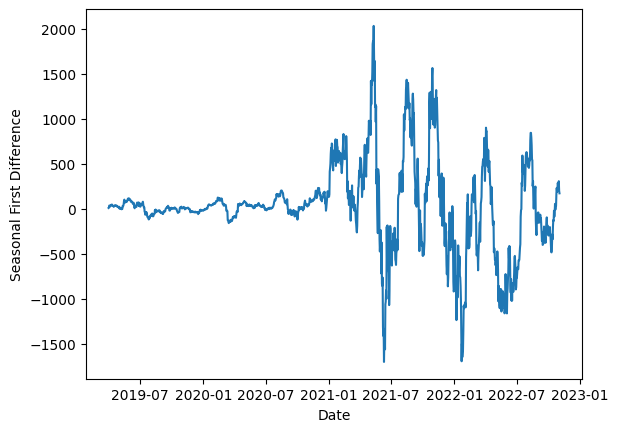

In [45]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Seasonal First Difference'])

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

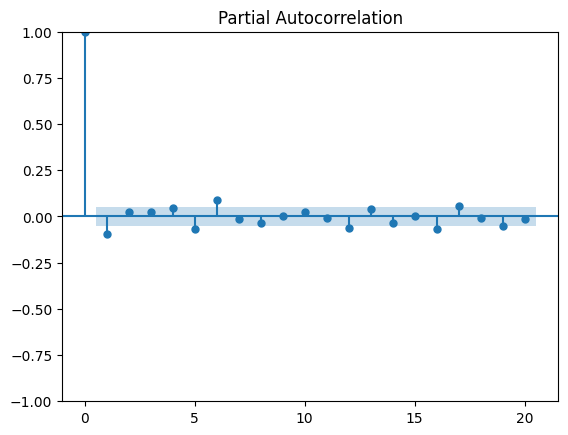

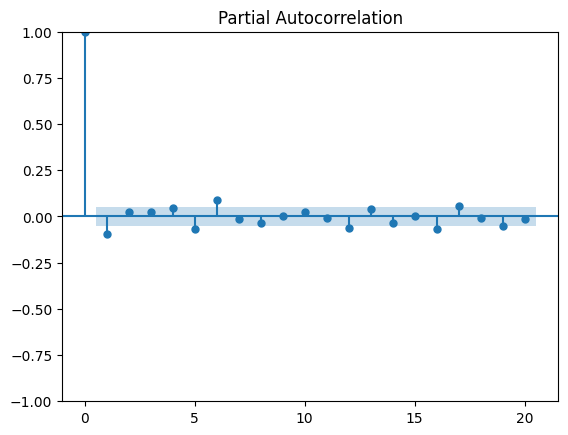

In [47]:
plot_pacf(train_data['First Difference'].dropna(),lags=20)

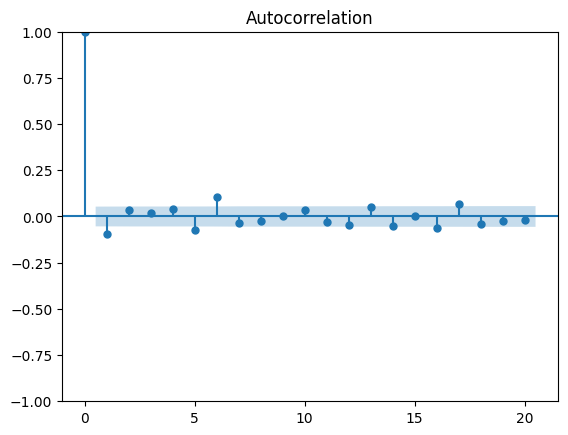

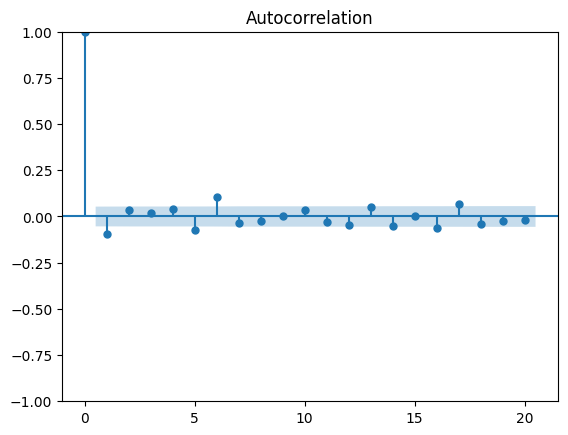

In [48]:
plot_acf(train_data['First Difference'].dropna(),lags=20)

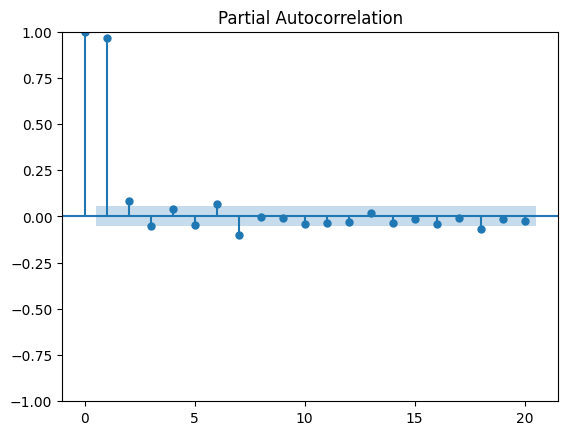

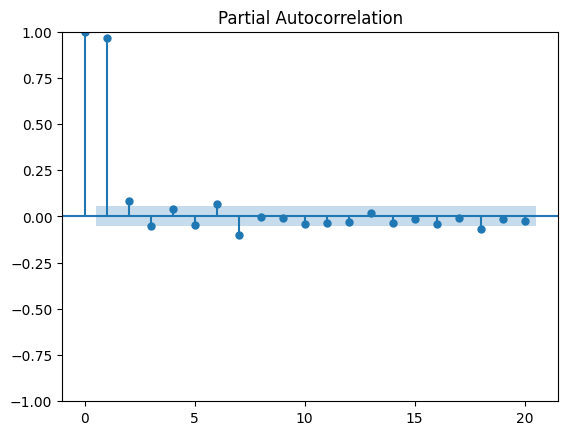

In [50]:
plot_pacf(train_data['Seasonal First Difference'].dropna(),lags=20)

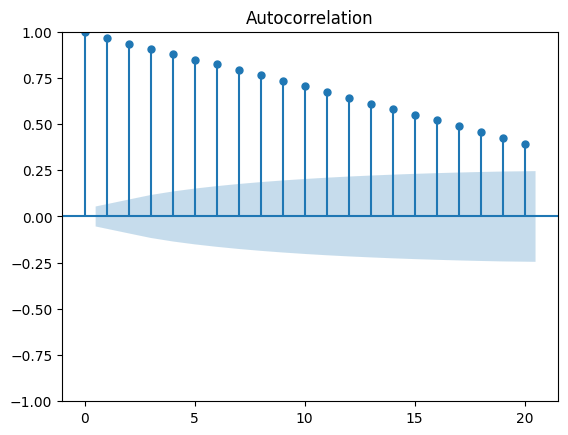

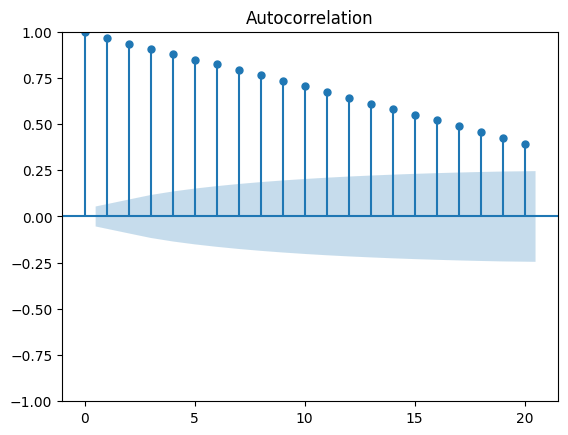

In [49]:
plot_acf(train_data['Seasonal First Difference'].dropna(),lags=20)

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [52]:
model = SARIMAX (train_data['Price'], order = (1,1,1), seasonal_order = (1,1,1,30))
model_fit = model.fit()

C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [53]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 1344
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -7840.806
Date:                            Wed, 05 Jun 2024   AIC                          15691.612
Time:                                    08:47:28   BIC                          15717.512
Sample:                                03-01-2019   HQIC                         15701.325
                                     - 11-03-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7962      0.059    -13.480      0.000      -0.912      -0.680
ma.L1          0.7294      0.070     10.393      0.000       0.592       0.867
ar.S.L30       0.0411      0.021      1.999      0.046       0.001       0.081
ma.S.L30      -0.9995      1.040     -0.961      0.336      -3.038       1.039
sigma2      8277.2199   8554.416      0.968      0.333   -8489.128     2.5e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):              8479.59
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):             146.68   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
test_prediction = model_fit.forecast(steps=len(test_data))
frame = {'Price':test_prediction[0:]}
test_prediction_df = pd.DataFrame(frame)

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test = np.array(test_data['Price'])
y_pred = np.array(test_prediction_df['Price'])

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 16.968137322448666
RMSE: 642.0932894948239
MAE: 421.99052577111706


In [56]:
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90)

In [57]:
future_prediction = model_fit.forecast(steps=len(test_data)+90)
frame = {'Price':future_prediction[0:]}
future_prediction_df = pd.DataFrame(frame)

In [58]:
next60days_df = future_prediction_df[-90:]
next60days_df = next60days_df[:60]
next60days_index = future_index[-90:]
next60days_index = next60days_index[:60]

next30days_df = future_prediction_df[-90:]
next30days_df = next30days_df[:30]
next30days_index = future_index[-90:]
next30days_index = next30days_index[:30]

Text(0, 0.5, 'Price')

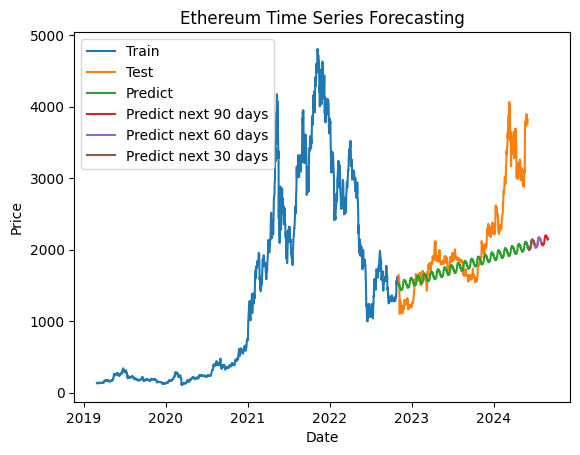

In [61]:
sns.lineplot(data=train_data, x=train_data.index, y=train_data['Price'],label='Train')
sns.lineplot(data=test_data, x=test_data.index, y=test_data['Price'],label='Test')
sns.lineplot(data=test_data, x=test_data.index, y=test_prediction,label='Predict')
sns.lineplot(data=future_prediction_df[-90:], x=future_index[:90], y=future_prediction_df['Price'][-90:],label='Predict next 90 days')
sns.lineplot(data=next60days_df, x=next60days_index, y=next60days_df['Price'],label='Predict next 60 days')
sns.lineplot(data=next30days_df, x=next30days_index, y=next30days_df['Price'],label='Predict next 30 days')
plt.title('Ethereum Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')

# 3. BNB/USD Dataset (Data split 7:3)

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [65]:
train_size = int(0.7 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size:]

In [66]:
from statsmodels.tsa.stattools import adfuller

In [67]:
def test_stationarity(variable):
    result=adfuller(variable)
    labels = ['t-statistics', 'p-value', 'lags_used', 'number of observations used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [68]:
test_stationarity(train_data['Price'])

t-statistics : -1.4582790920399227
p-value : 0.5540399614490752
lags_used : 21
number of observations used : 1322
Data is non-stationary 


<Axes: xlabel='Date', ylabel='Price'>

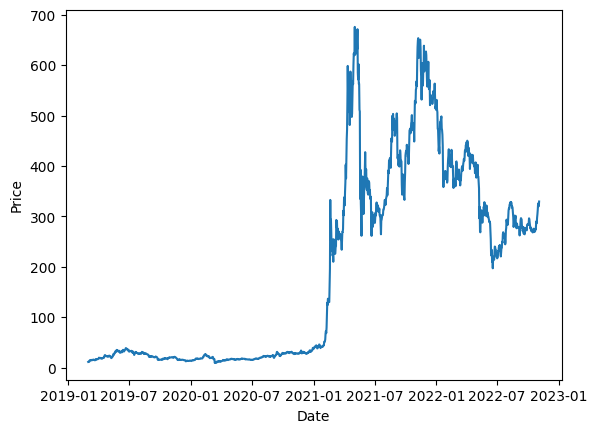

In [69]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Price'])

In [70]:
train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\220069074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)


In [71]:
train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\2698099252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)


In [73]:
test_stationarity(train_data['First Difference'].dropna())

t-statistics : -7.153135716380055
p-value : 3.103630720137591e-10
lags_used : 23
number of observations used : 1319
Data is stationary


<Axes: xlabel='Date', ylabel='First Difference'>

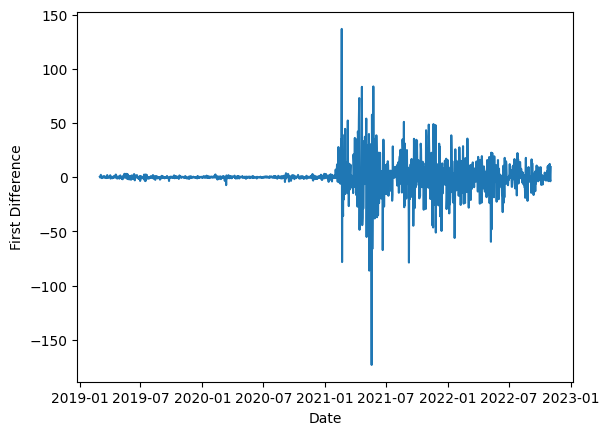

In [74]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['First Difference'])

In [75]:
test_stationarity(train_data['Seasonal First Difference'].dropna())

t-statistics : -6.085278326415458
p-value : 1.0680928137101933e-07
lags_used : 21
number of observations used : 1292
Data is stationary


<Axes: xlabel='Date', ylabel='Seasonal First Difference'>

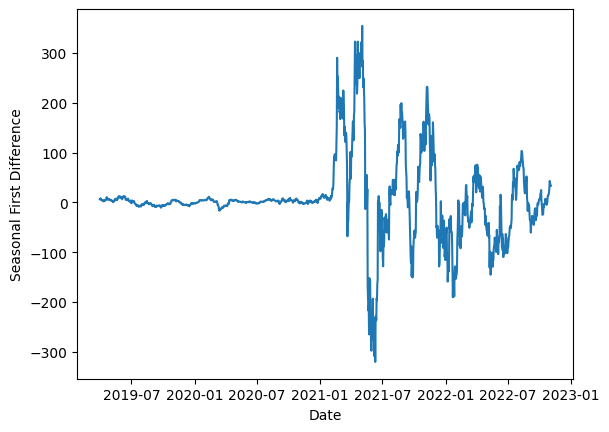

In [76]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Seasonal First Difference'])

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

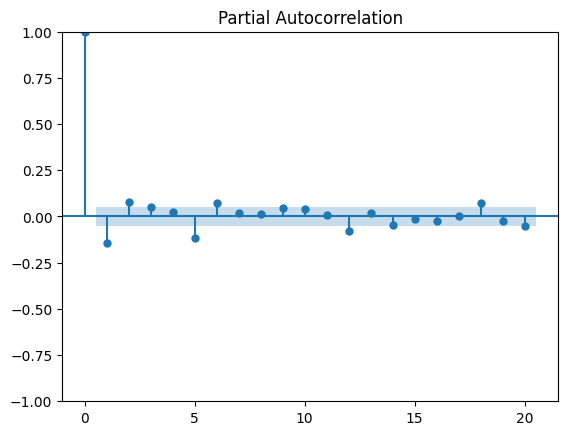

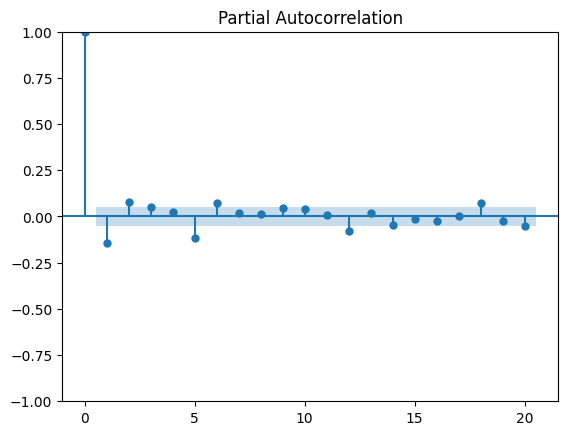

In [78]:
plot_pacf(train_data['First Difference'].dropna(),lags=20)

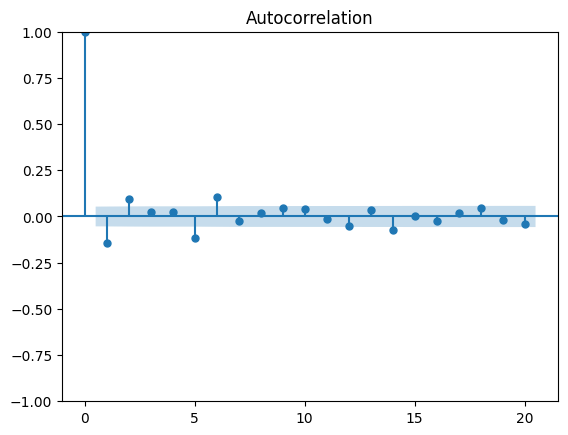

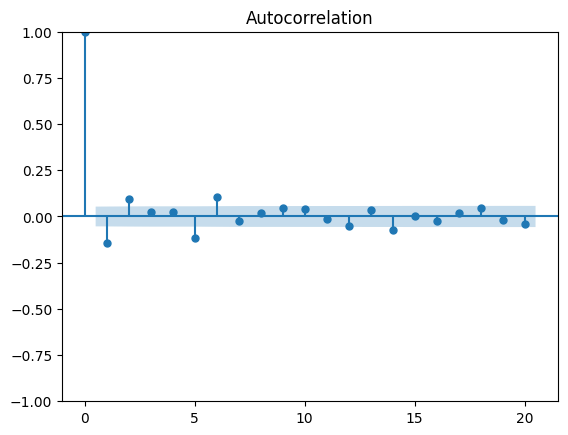

In [79]:
plot_acf(train_data['First Difference'].dropna(),lags=20)

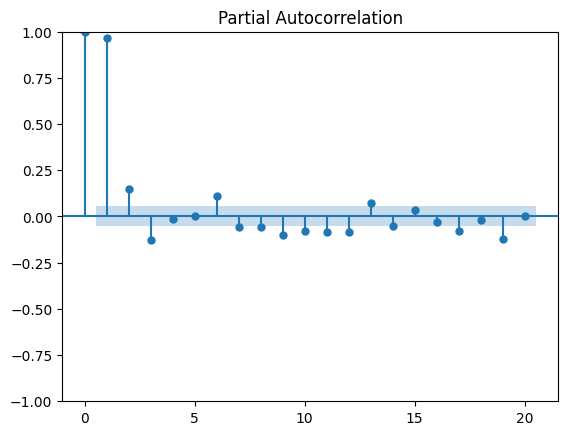

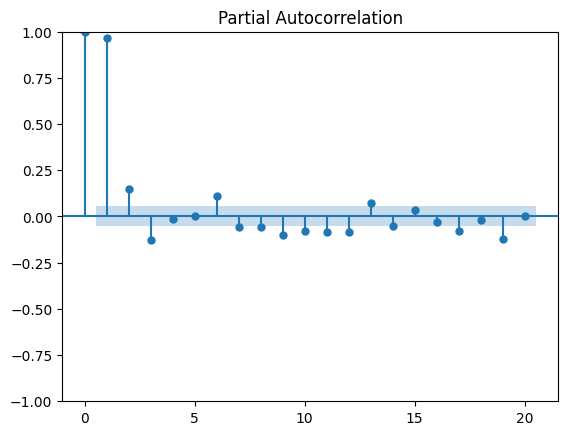

In [80]:
plot_pacf(train_data['Seasonal First Difference'].dropna(),lags=20)

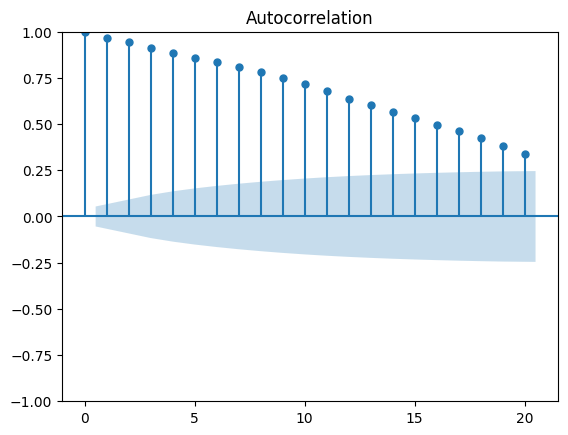

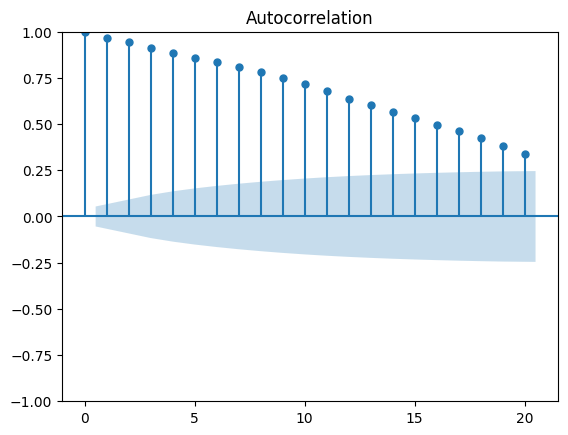

In [81]:
plot_acf(train_data['Seasonal First Difference'].dropna(),lags=20)

In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [83]:
model = SARIMAX (train_data['Price'], order = (1,1,1), seasonal_order = (1,1,1,30))
model_fit = model.fit()

C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [84]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 1344
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -5425.936
Date:                            Wed, 05 Jun 2024   AIC                          10861.872
Time:                                    08:55:12   BIC                          10887.773
Sample:                                03-01-2019   HQIC                         10871.585
                                     - 11-03-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7107      0.051    -13.996      0.000      -0.810      -0.611
ma.L1          0.5954      0.058     10.242      0.000       0.481       0.709
ar.S.L30       0.0388      0.020      1.946      0.052      -0.000       0.078
ma.S.L30      -0.9999      4.111     -0.243      0.808      -9.058       7.058
sigma2       208.9401    857.423      0.244      0.807   -1471.579    1889.459
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):             34289.96
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):             251.28   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
test_prediction = model_fit.forecast(steps=len(test_data))
frame = {'Price':test_prediction[0:]}
test_prediction_df = pd.DataFrame(frame)

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test = np.array(test_data['Price'])
y_pred = np.array(test_prediction_df['Price'])

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 37.61580562885275
RMSE: 119.44953744196957
MAE: 105.42653932719831


In [87]:
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90)

In [88]:
future_prediction = model_fit.forecast(steps=len(test_data)+90)
frame = {'Price':future_prediction[0:]}
future_prediction_df = pd.DataFrame(frame)

In [89]:
next60days_df = future_prediction_df[-90:]
next60days_df = next60days_df[:60]
next60days_index = future_index[-90:]
next60days_index = next60days_index[:60]

next30days_df = future_prediction_df[-90:]
next30days_df = next30days_df[:30]
next30days_index = future_index[-90:]
next30days_index = next30days_index[:30]

Text(0, 0.5, 'Price')

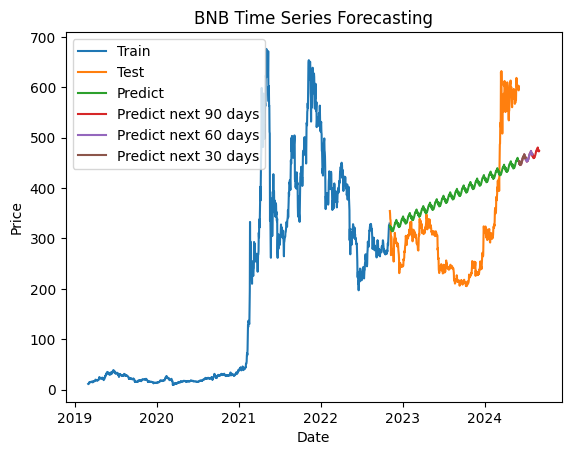

In [91]:
sns.lineplot(data=train_data, x=train_data.index, y=train_data['Price'],label='Train')
sns.lineplot(data=test_data, x=test_data.index, y=test_data['Price'],label='Test')
sns.lineplot(data=test_data, x=test_data.index, y=test_prediction,label='Predict')
sns.lineplot(data=future_prediction_df[-90:], x=future_index[:90], y=future_prediction_df['Price'][-90:],label='Predict next 90 days')
sns.lineplot(data=next60days_df, x=next60days_index, y=next60days_df['Price'],label='Predict next 60 days')
sns.lineplot(data=next30days_df, x=next30days_index, y=next30days_df['Price'],label='Predict next 30 days')
plt.title('BNB Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')

# 4. BTC/USD Dataset (Data split 8:2)

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df.set_index('Date',inplace=True)
df = df[['Price']]

In [94]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size:]

In [95]:
from statsmodels.tsa.stattools import adfuller

In [96]:
def test_stationarity(variable):
    result=adfuller(variable)
    labels = ['t-statistics', 'p-value', 'lags_used', 'number of observations used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [97]:
test_stationarity(train_data['Price'])

t-statistics : -1.6399506303086384
p-value : 0.46228659004370704
lags_used : 9
number of observations used : 1526
Data is non-stationary 


<Axes: xlabel='Date', ylabel='Price'>

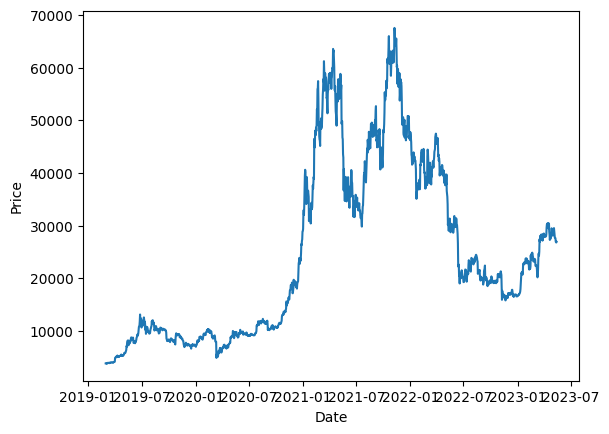

In [98]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Price'])

In [99]:
train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\220069074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)


In [100]:
train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\2698099252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)


In [101]:
test_stationarity(train_data['First Difference'].dropna())

t-statistics : -12.45707789104468
p-value : 3.471689650111752e-23
lags_used : 8
number of observations used : 1526
Data is stationary


<Axes: xlabel='Date', ylabel='First Difference'>

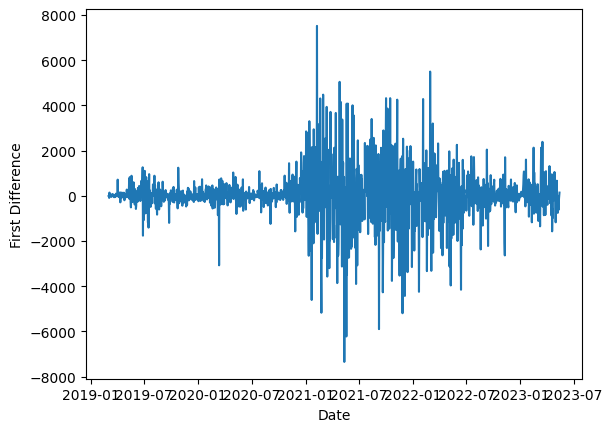

In [102]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['First Difference'])

In [103]:
test_stationarity(train_data['Seasonal First Difference'].dropna())

t-statistics : -5.148300987179027
p-value : 1.1200339876506118e-05
lags_used : 11
number of observations used : 1494
Data is stationary


<Axes: xlabel='Date', ylabel='Seasonal First Difference'>

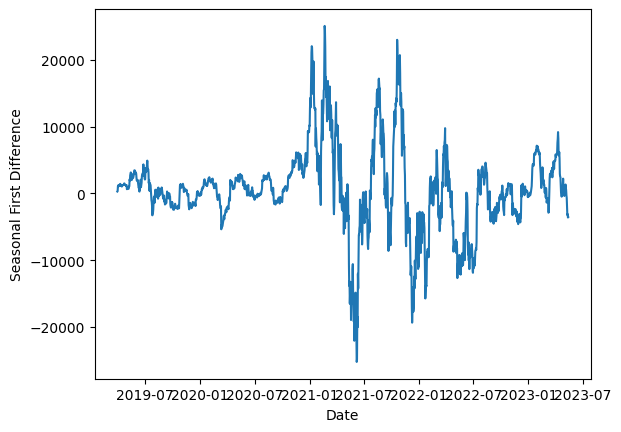

In [104]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Seasonal First Difference'])

In [105]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

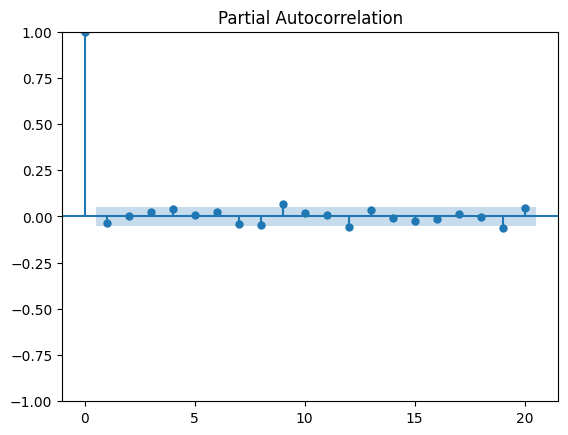

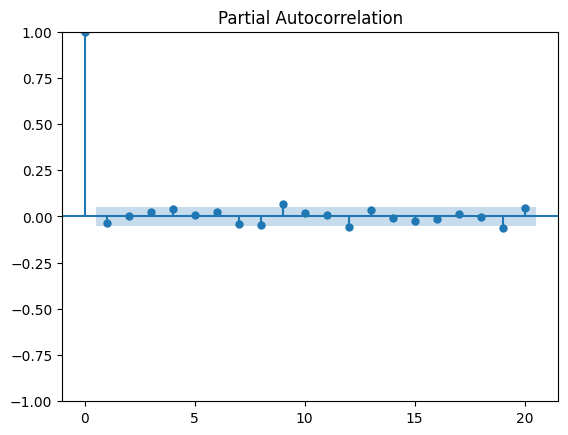

In [106]:
plot_pacf(train_data['First Difference'].dropna(),lags=20)

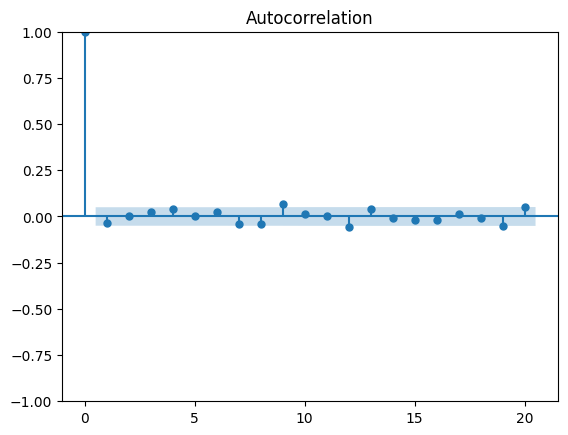

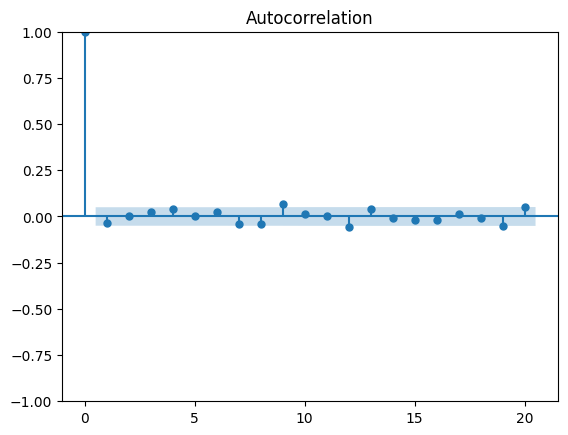

In [107]:
plot_acf(train_data['First Difference'].dropna(),lags=20)

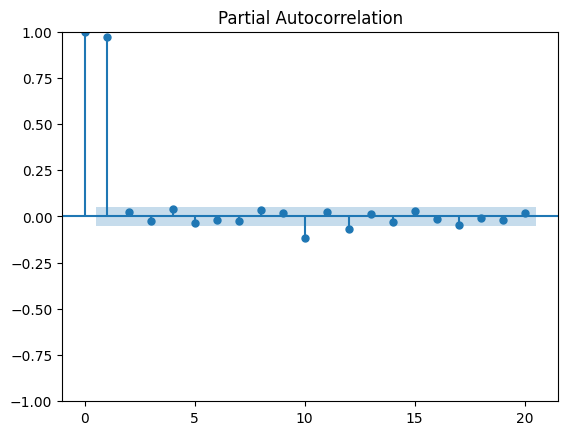

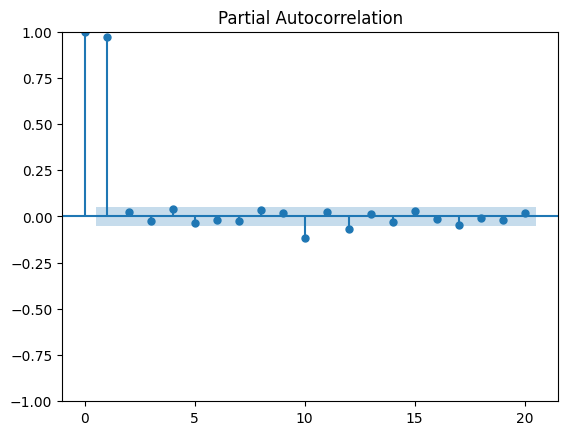

In [108]:
plot_pacf(train_data['Seasonal First Difference'].dropna(),lags=20)

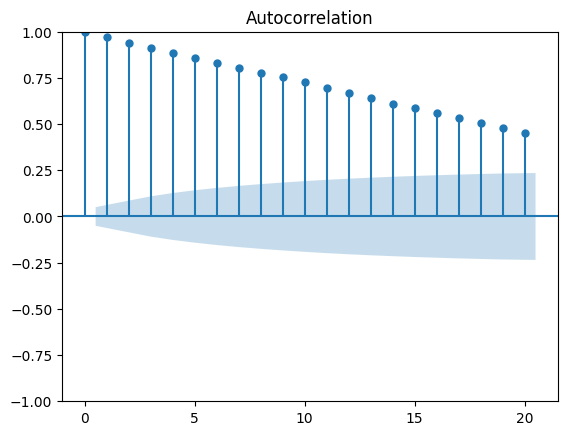

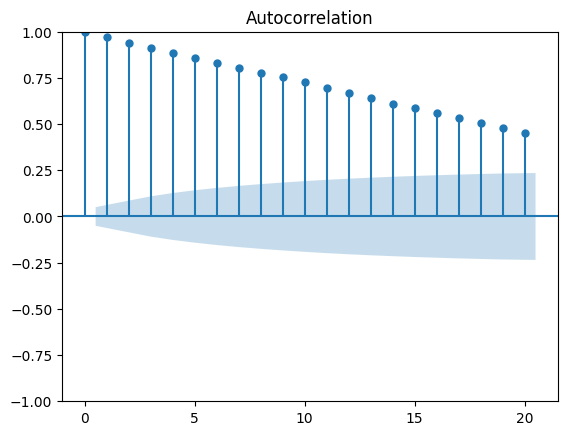

In [109]:
plot_acf(train_data['Seasonal First Difference'].dropna(),lags=20)

In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [127]:
model = SARIMAX (train_data['Price'], order = (1,1,1), seasonal_order = (1,1,1,30))
model_fit = model.fit()

C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [128]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 1536
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood              -12739.668
Date:                            Wed, 05 Jun 2024   AIC                          25489.337
Time:                                    09:35:19   BIC                          25515.920
Sample:                                03-01-2019   HQIC                         25499.238
                                     - 05-14-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9991      0.140      7.158      0.000       0.726       1.273
ma.L1         -0.9990      0.137     -7.279      0.000      -1.268      -0.730
ar.S.L30       0.0215      0.021      1.000      0.317      -0.021       0.064
ma.S.L30      -0.9999      0.017    -57.396      0.000      -1.034      -0.966
sigma2      1.229e+06   6.78e-08   1.81e+13      0.000    1.23e+06    1.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.63   Jarque-Bera (JB):              3368.49
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               6.97   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.34e+29. Standard errors may be unstable.
"""

In [129]:
test_prediction = model_fit.forecast(steps=len(test_data))
frame = {'Price':test_prediction[0:]}
test_prediction_df = pd.DataFrame(frame)

In [130]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test = np.array(test_data['Price'])
y_pred = np.array(test_prediction_df['Price'])

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 23.68650651501685
RMSE: 18183.716809049714
MAE: 12728.521450083788


In [131]:
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90)

In [132]:
future_prediction = model_fit.forecast(steps=len(test_data)+90)
frame = {'Price':future_prediction[0:]}
future_prediction_df = pd.DataFrame(frame)

In [133]:
next60days_df = future_prediction_df[-90:]
next60days_df = next60days_df[:60]
next60days_index = future_index[-90:]
next60days_index = next60days_index[:60]

next30days_df = future_prediction_df[-90:]
next30days_df = next30days_df[:30]
next30days_index = future_index[-90:]
next30days_index = next30days_index[:30]

Text(0, 0.5, 'Price')

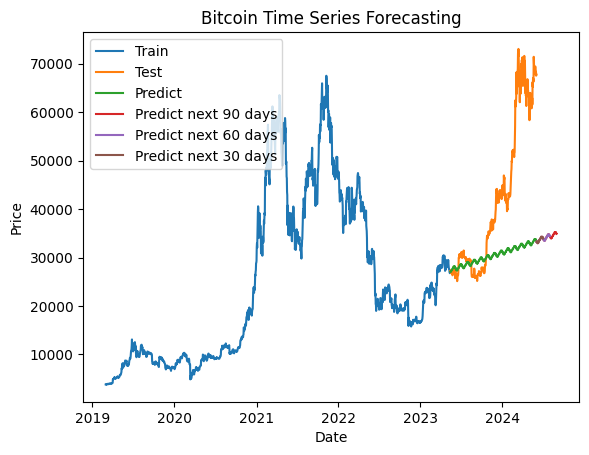

In [134]:
sns.lineplot(data=train_data, x=train_data.index, y=train_data['Price'],label='Train')
sns.lineplot(data=test_data, x=test_data.index, y=test_data['Price'],label='Test')
sns.lineplot(data=test_data, x=test_data.index, y=test_prediction,label='Predict')
sns.lineplot(data=future_prediction_df[-90:], x=future_index[:90], y=future_prediction_df['Price'][-90:],label='Predict next 90 days')
sns.lineplot(data=next60days_df, x=next60days_index, y=next60days_df['Price'],label='Predict next 60 days')
sns.lineplot(data=next30days_df, x=next30days_index, y=next30days_df['Price'],label='Predict next 30 days')
plt.title('Bitcoin Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')

# 5. ETH/USD Dataset (Data split 8:2)

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df.set_index('Date',inplace=True)
df = df[['Price']]

In [137]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size:]

In [138]:
from statsmodels.tsa.stattools import adfuller

In [139]:
def test_stationarity(variable):
    result=adfuller(variable)
    labels = ['t-statistics', 'p-value', 'lags_used', 'number of observations used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [140]:
test_stationarity(train_data['Price'])

t-statistics : -1.4684104797865103
p-value : 0.5490763572134386
lags_used : 17
number of observations used : 1518
Data is non-stationary 


<Axes: xlabel='Date', ylabel='Price'>

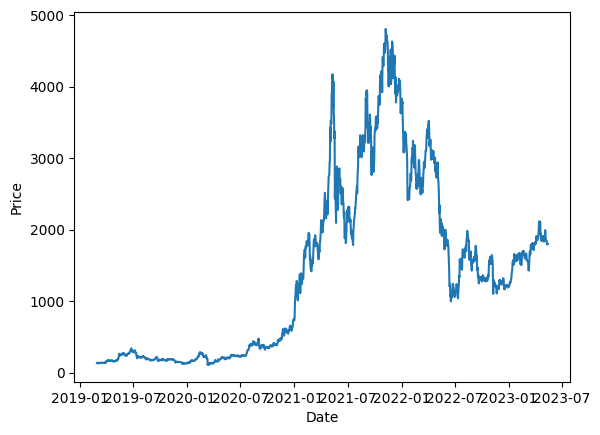

In [141]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Price'])

In [142]:
train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\220069074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)


In [143]:
train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\2698099252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)


In [144]:
test_stationarity(train_data['First Difference'].dropna())

t-statistics : -9.790862558602406
p-value : 6.359115703117336e-17
lags_used : 16
number of observations used : 1518
Data is stationary


<Axes: xlabel='Date', ylabel='First Difference'>

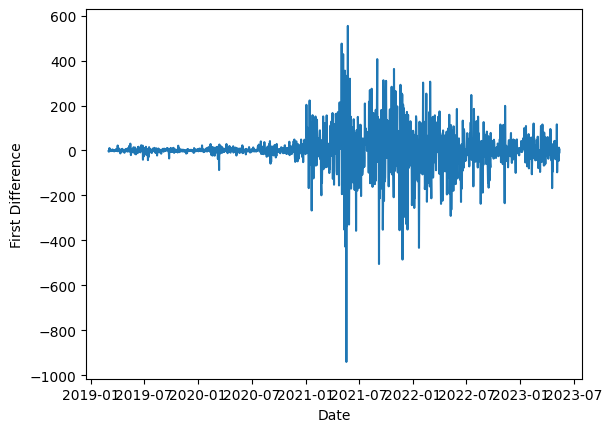

In [145]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['First Difference'])

In [146]:
test_stationarity(train_data['Seasonal First Difference'].dropna())

t-statistics : -5.00831384273344
p-value : 2.136751471048037e-05
lags_used : 6
number of observations used : 1499
Data is stationary


<Axes: xlabel='Date', ylabel='Seasonal First Difference'>

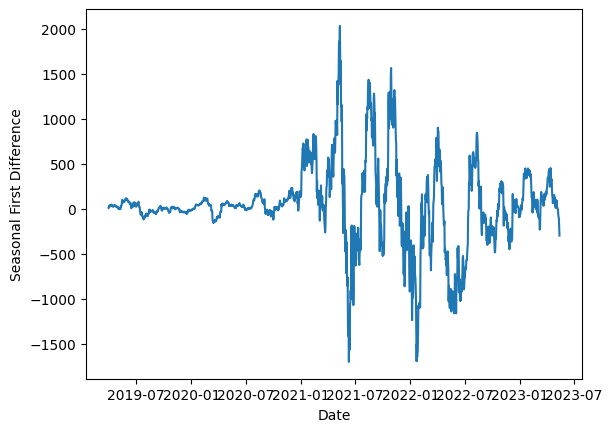

In [147]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Seasonal First Difference'])

In [148]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

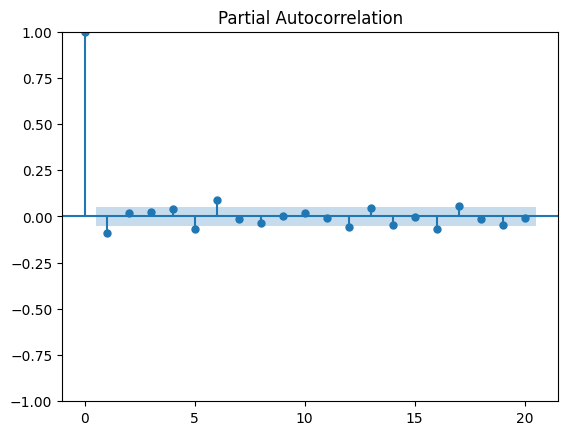

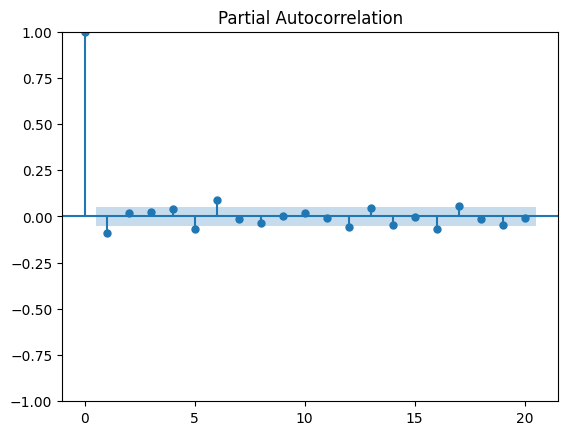

In [149]:
plot_pacf(train_data['First Difference'].dropna(),lags=20)

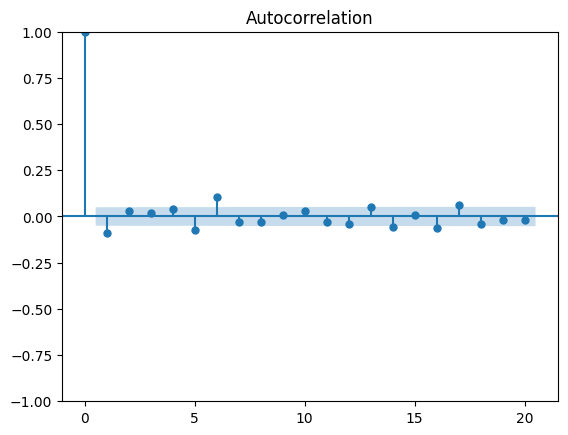

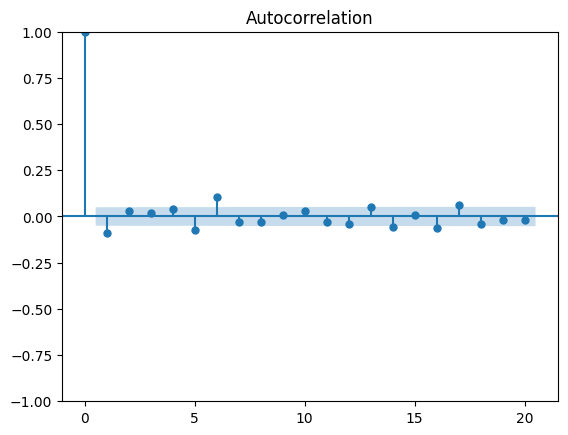

In [150]:
plot_acf(train_data['First Difference'].dropna(),lags=20)

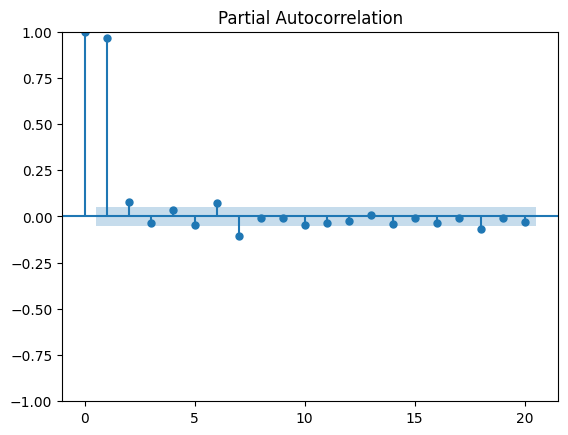

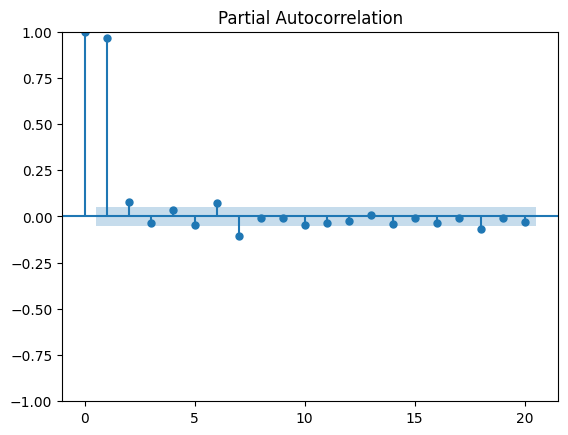

In [151]:
plot_pacf(train_data['Seasonal First Difference'].dropna(),lags=20)

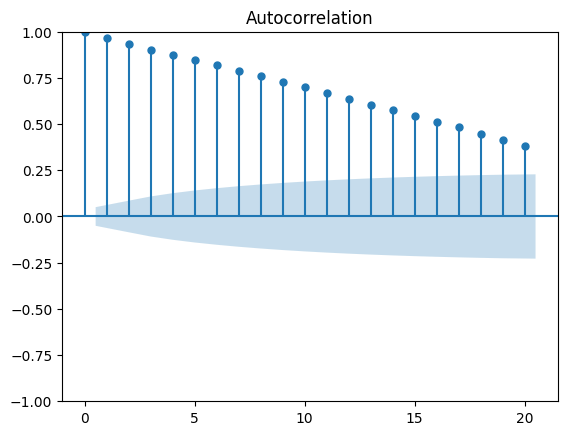

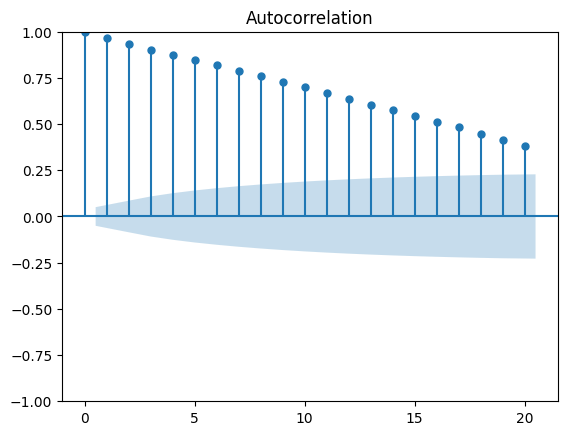

In [152]:
plot_acf(train_data['Seasonal First Difference'].dropna(),lags=20)

In [153]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [154]:
model = SARIMAX (train_data['Price'], order = (1,1,1), seasonal_order = (1,1,1,30))
model_fit = model.fit()

C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [155]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 1536
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -8918.279
Date:                            Wed, 05 Jun 2024   AIC                          17846.559
Time:                                    09:39:15   BIC                          17873.142
Sample:                                03-01-2019   HQIC                         17856.460
                                     - 05-14-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7869      0.058    -13.666      0.000      -0.900      -0.674
ma.L1          0.7217      0.068     10.642      0.000       0.589       0.855
ar.S.L30       0.0427      0.019      2.279      0.023       0.006       0.079
ma.S.L30      -0.9990      0.458     -2.181      0.029      -1.897      -0.101
sigma2      7616.5495   3446.562      2.210      0.027     861.412    1.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):             10772.49
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):              69.62   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [156]:
test_prediction = model_fit.forecast(steps=len(test_data))
frame = {'Price':test_prediction[0:]}
test_prediction_df = pd.DataFrame(frame)

In [157]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test = np.array(test_data['Price'])
y_pred = np.array(test_prediction_df['Price'])

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 16.6566126013015
RMSE: 670.5862596937045
MAE: 460.5116922548298


In [158]:
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90)

In [159]:
future_prediction = model_fit.forecast(steps=len(test_data)+90)
frame = {'Price':future_prediction[0:]}
future_prediction_df = pd.DataFrame(frame)

In [160]:
next60days_df = future_prediction_df[-90:]
next60days_df = next60days_df[:60]
next60days_index = future_index[-90:]
next60days_index = next60days_index[:60]

next30days_df = future_prediction_df[-90:]
next30days_df = next30days_df[:30]
next30days_index = future_index[-90:]
next30days_index = next30days_index[:30]

Text(0, 0.5, 'Price')

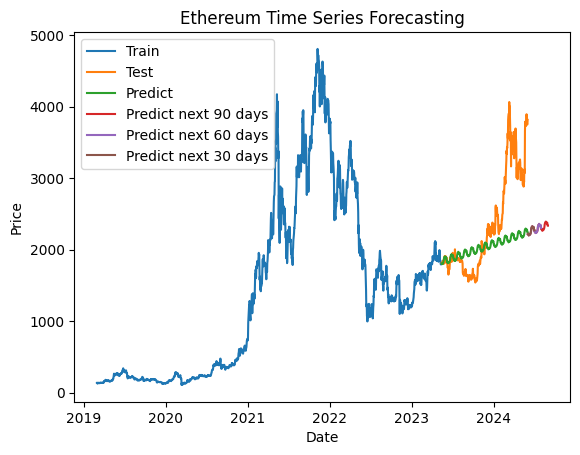

In [162]:
sns.lineplot(data=train_data, x=train_data.index, y=train_data['Price'],label='Train')
sns.lineplot(data=test_data, x=test_data.index, y=test_data['Price'],label='Test')
sns.lineplot(data=test_data, x=test_data.index, y=test_prediction,label='Predict')
sns.lineplot(data=future_prediction_df[-90:], x=future_index[:90], y=future_prediction_df['Price'][-90:],label='Predict next 90 days')
sns.lineplot(data=next60days_df, x=next60days_index, y=next60days_df['Price'],label='Predict next 60 days')
sns.lineplot(data=next30days_df, x=next30days_index, y=next30days_df['Price'],label='Predict next 30 days')
plt.title('Ethereum Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')

# 6. BNB/USD Dataset (Data split 8:2)

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [164]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [165]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size:]

In [166]:
from statsmodels.tsa.stattools import adfuller

In [167]:
def test_stationarity(variable):
    result=adfuller(variable)
    labels = ['t-statistics', 'p-value', 'lags_used', 'number of observations used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [168]:
test_stationarity(train_data['Price'])

t-statistics : -1.5902395585045759
p-value : 0.4884946460830962
lags_used : 24
number of observations used : 1511
Data is non-stationary 


<Axes: xlabel='Date', ylabel='Price'>

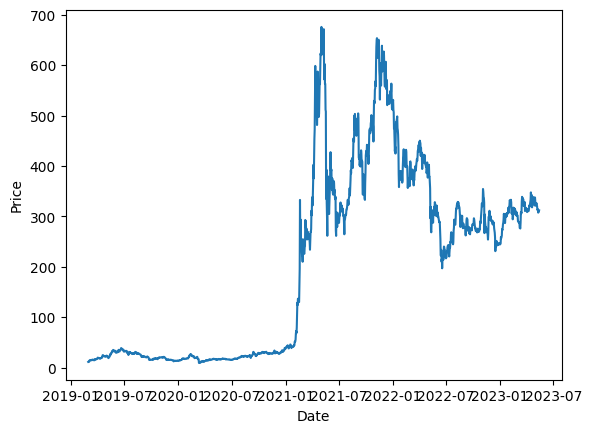

In [169]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Price'])

In [170]:
train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\220069074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)


In [171]:
train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\2698099252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)


In [172]:
test_stationarity(train_data['First Difference'].dropna())

t-statistics : -7.309134500732602
p-value : 1.2780017394284347e-10
lags_used : 24
number of observations used : 1510
Data is stationary


<Axes: xlabel='Date', ylabel='First Difference'>

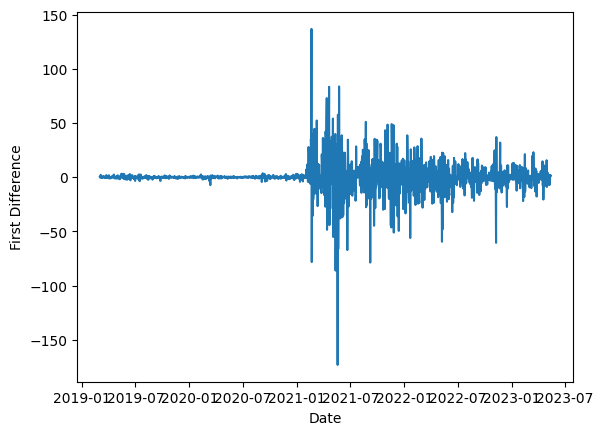

In [173]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['First Difference'])

In [174]:
test_stationarity(train_data['Seasonal First Difference'].dropna())

t-statistics : -6.616110228555948
p-value : 6.20149547588447e-09
lags_used : 24
number of observations used : 1481
Data is stationary


<Axes: xlabel='Date', ylabel='Seasonal First Difference'>

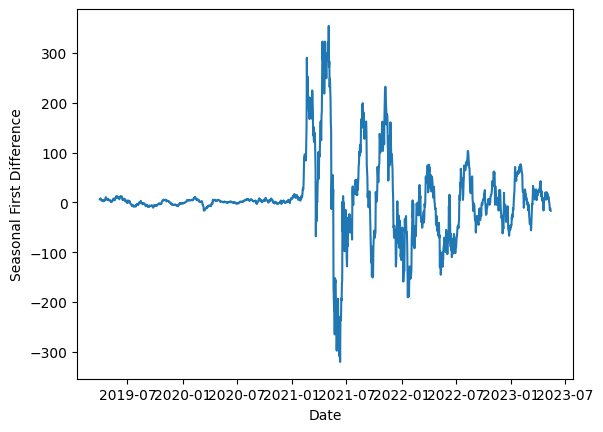

In [175]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Seasonal First Difference'])

In [176]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

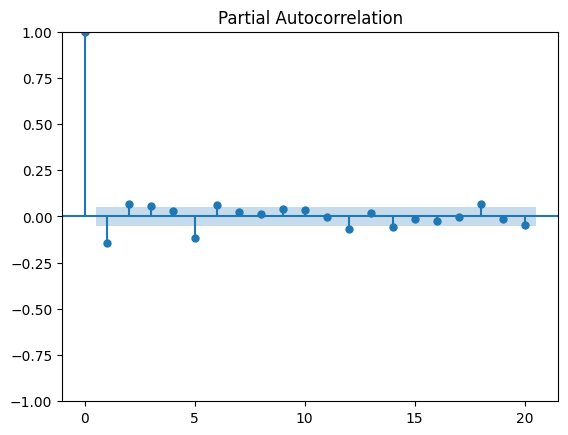

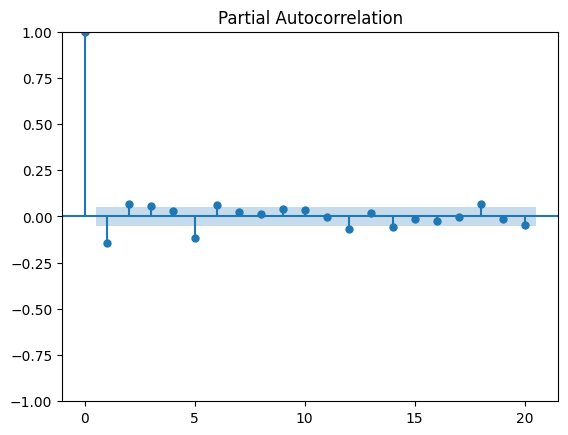

In [177]:
plot_pacf(train_data['First Difference'].dropna(),lags=20)

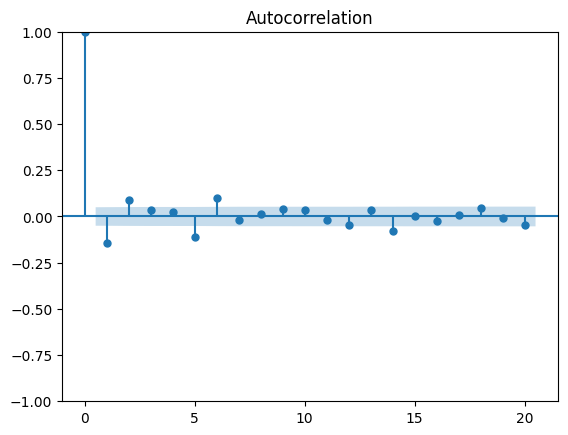

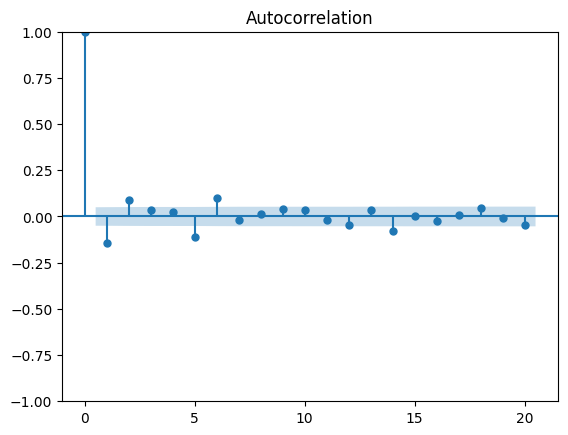

In [178]:
plot_acf(train_data['First Difference'].dropna(),lags=20)

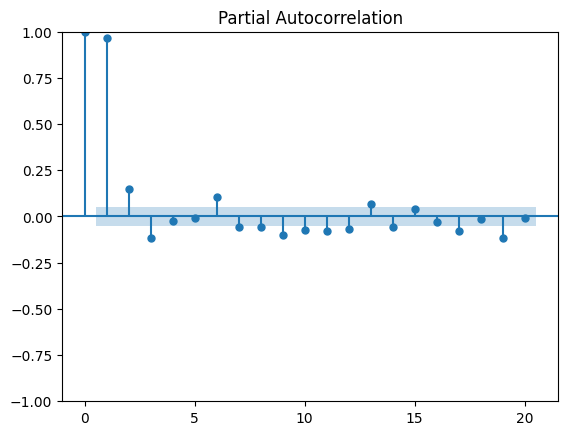

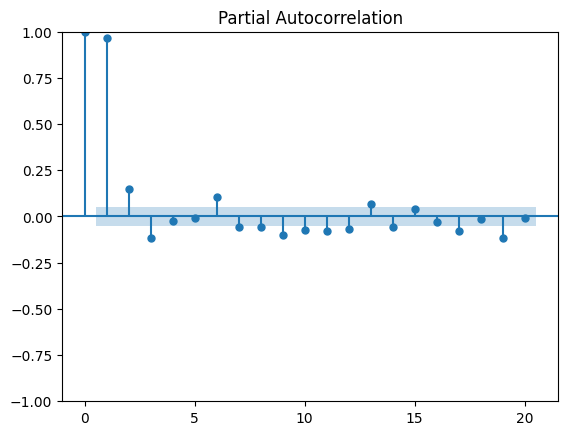

In [179]:
plot_pacf(train_data['Seasonal First Difference'].dropna(),lags=20)

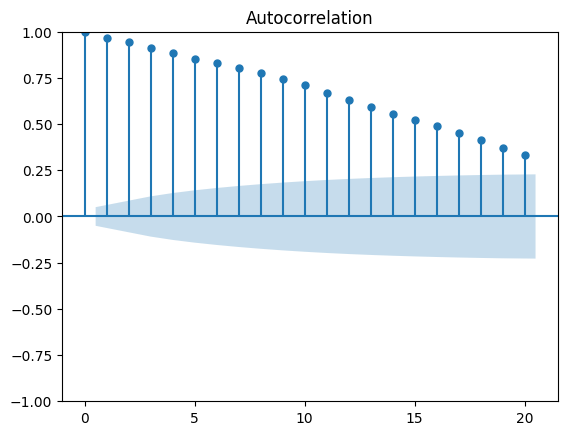

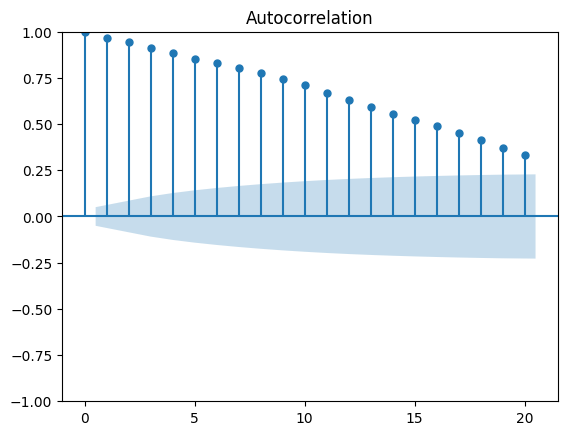

In [180]:
plot_acf(train_data['Seasonal First Difference'].dropna(),lags=20)

In [181]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [182]:
model = SARIMAX (train_data['Price'], order = (1,1,1), seasonal_order = (1,1,1,30))
model_fit = model.fit()

C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [183]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 1536
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -6159.244
Date:                            Wed, 05 Jun 2024   AIC                          12328.488
Time:                                    09:44:01   BIC                          12355.071
Sample:                                03-01-2019   HQIC                         12338.390
                                     - 05-14-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5072      0.066     -7.642      0.000      -0.637      -0.377
ma.L1          0.3686      0.072      5.132      0.000       0.228       0.509
ar.S.L30       0.0435      0.018      2.378      0.017       0.008       0.079
ma.S.L30      -0.9998      2.177     -0.459      0.646      -5.266       3.266
sigma2       194.5323    422.070      0.461      0.645    -632.710    1021.774
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             43726.91
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):             149.39   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [184]:
test_prediction = model_fit.forecast(steps=len(test_data))
frame = {'Price':test_prediction[0:]}
test_prediction_df = pd.DataFrame(frame)

In [185]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test = np.array(test_data['Price'])
y_pred = np.array(test_prediction_df['Price'])

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 35.96503458277809
RMSE: 125.43453679656572
MAE: 111.44659206623953


In [186]:
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90)

In [187]:
future_prediction = model_fit.forecast(steps=len(test_data)+90)
frame = {'Price':future_prediction[0:]}
future_prediction_df = pd.DataFrame(frame)

In [188]:
next60days_df = future_prediction_df[-90:]
next60days_df = next60days_df[:60]
next60days_index = future_index[-90:]
next60days_index = next60days_index[:60]

next30days_df = future_prediction_df[-90:]
next30days_df = next30days_df[:30]
next30days_index = future_index[-90:]
next30days_index = next30days_index[:30]

Text(0, 0.5, 'Price')

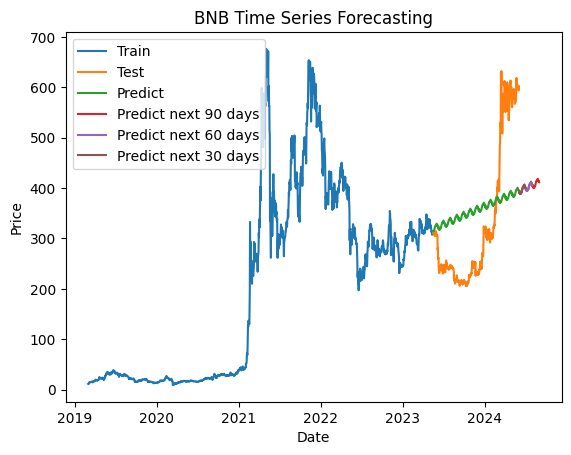

In [189]:
sns.lineplot(data=train_data, x=train_data.index, y=train_data['Price'],label='Train')
sns.lineplot(data=test_data, x=test_data.index, y=test_data['Price'],label='Test')
sns.lineplot(data=test_data, x=test_data.index, y=test_prediction,label='Predict')
sns.lineplot(data=future_prediction_df[-90:], x=future_index[:90], y=future_prediction_df['Price'][-90:],label='Predict next 90 days')
sns.lineplot(data=next60days_df, x=next60days_index, y=next60days_df['Price'],label='Predict next 60 days')
sns.lineplot(data=next30days_df, x=next30days_index, y=next30days_df['Price'],label='Predict next 30 days')
plt.title('BNB Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')

# 7. BTC/USD Dataset (Data split 9:1)

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [191]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df.set_index('Date',inplace=True)
df = df[['Price']]

In [192]:
train_size = int(0.9 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size:]

In [193]:
from statsmodels.tsa.stattools import adfuller

In [194]:
def test_stationarity(variable):
    result=adfuller(variable)
    labels = ['t-statistics', 'p-value', 'lags_used', 'number of observations used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [195]:
test_stationarity(train_data['Price'])

t-statistics : -1.6383865615943773
p-value : 0.4631039851824099
lags_used : 12
number of observations used : 1715
Data is non-stationary 


<Axes: xlabel='Date', ylabel='Price'>

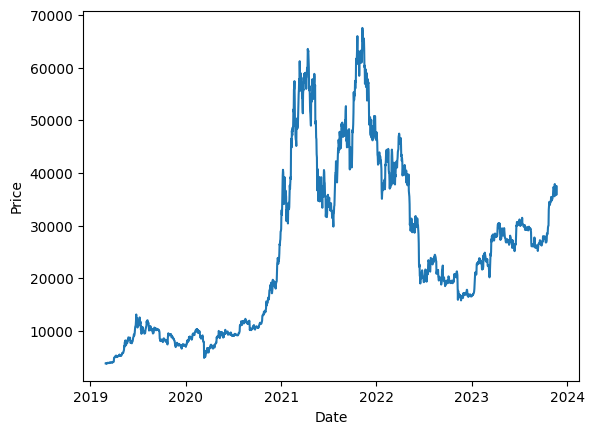

In [196]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Price'])

In [197]:
train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\220069074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)


In [198]:
train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\2698099252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)


In [199]:
test_stationarity(train_data['First Difference'].dropna())

t-statistics : -11.903552057842324
p-value : 5.503144573449609e-22
lags_used : 11
number of observations used : 1715
Data is stationary


<Axes: xlabel='Date', ylabel='First Difference'>

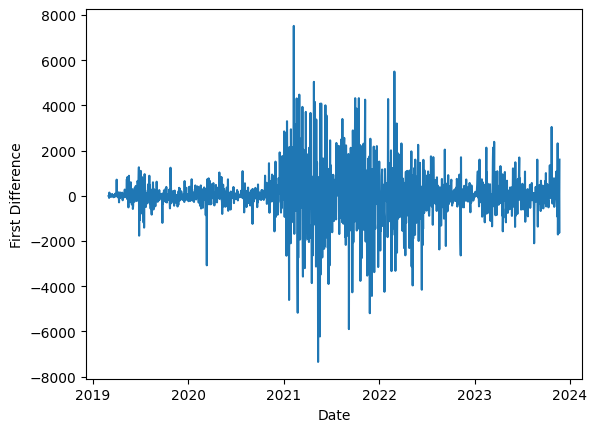

In [200]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['First Difference'])

In [201]:
test_stationarity(train_data['Seasonal First Difference'].dropna())

t-statistics : -5.454142677027631
p-value : 2.6044074076479636e-06
lags_used : 11
number of observations used : 1686
Data is stationary


<Axes: xlabel='Date', ylabel='Seasonal First Difference'>

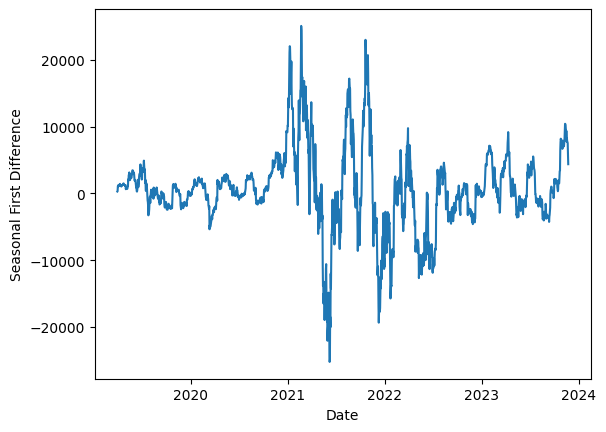

In [202]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Seasonal First Difference'])

In [203]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

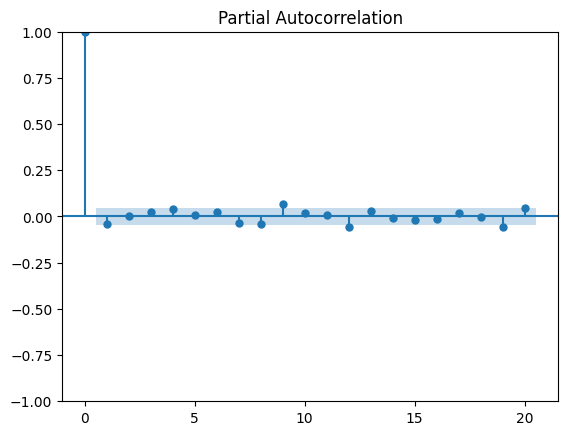

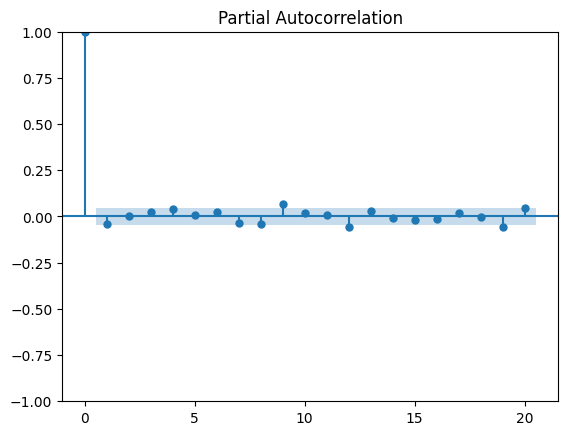

In [204]:
plot_pacf(train_data['First Difference'].dropna(),lags=20)

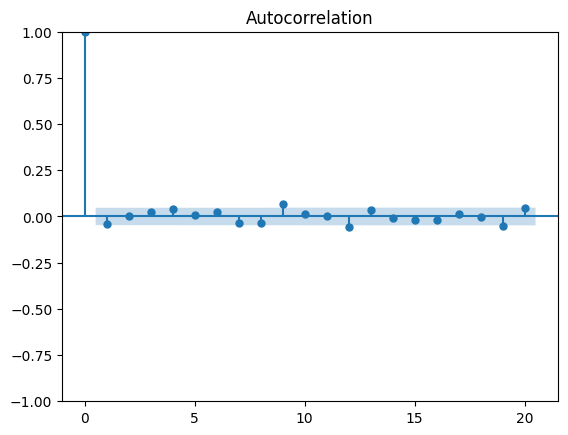

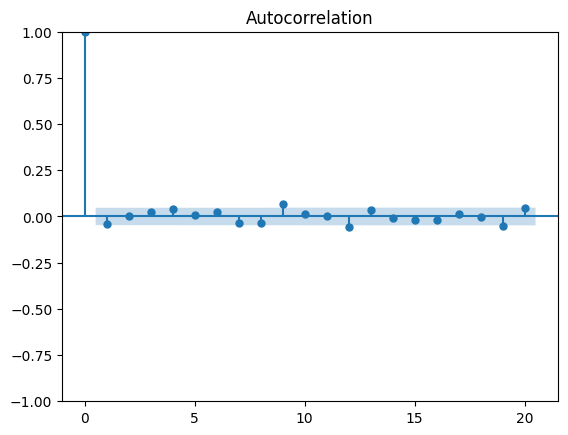

In [205]:
plot_acf(train_data['First Difference'].dropna(),lags=20)

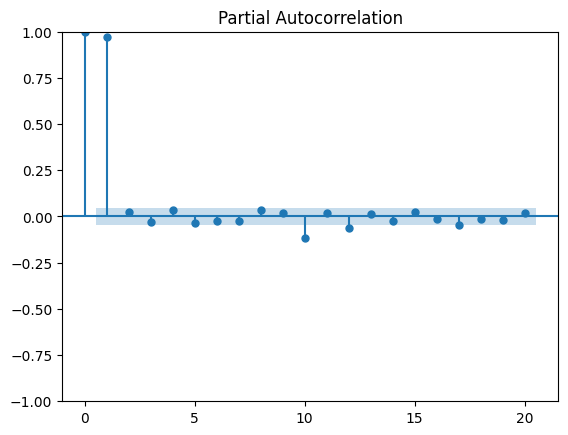

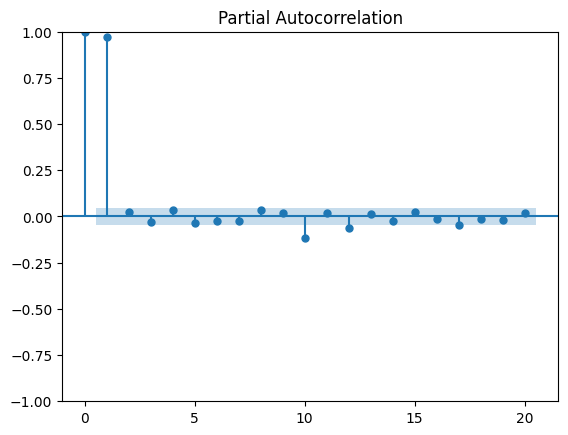

In [206]:
plot_pacf(train_data['Seasonal First Difference'].dropna(),lags=20)

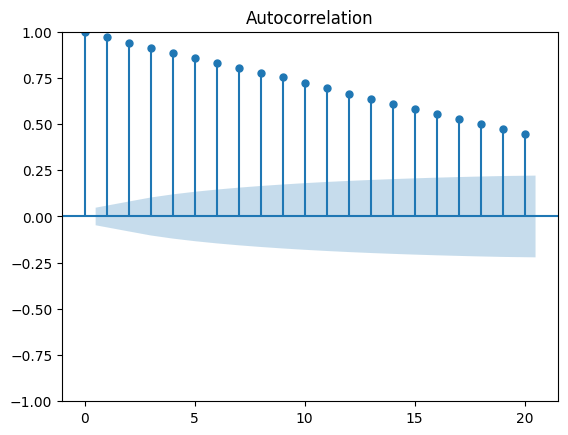

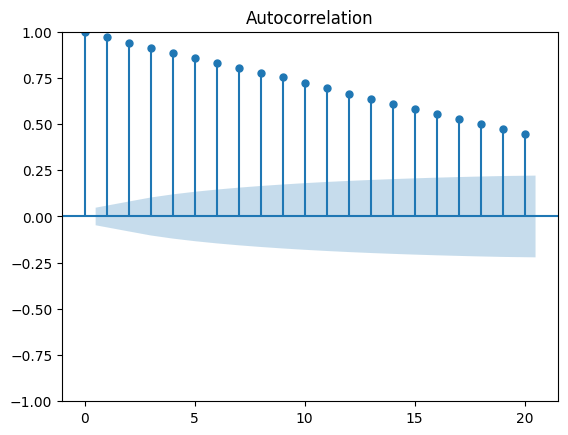

In [207]:
plot_acf(train_data['Seasonal First Difference'].dropna(),lags=20)

In [208]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [209]:
model = SARIMAX (train_data['Price'], order = (1,1,1), seasonal_order = (1,1,1,30))
model_fit = model.fit()

C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [210]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 1728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood              -14310.193
Date:                            Wed, 05 Jun 2024   AIC                          28630.385
Time:                                    09:50:11   BIC                          28657.568
Sample:                                03-01-2019   HQIC                         28640.449
                                     - 11-22-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      1.131      0.884      0.377      -1.217       3.217
ma.L1         -0.9999      1.173     -0.853      0.394      -3.298       1.298
ar.S.L30      -0.0094      0.024     -0.385      0.700      -0.057       0.038
ma.S.L30      -0.9998      0.119     -8.384      0.000      -1.234      -0.766
sigma2      1.409e+06   4.37e-06   3.23e+11      0.000    1.41e+06    1.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.19   Jarque-Bera (JB):              4412.24
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               4.21   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.12e+26. Standard errors may be unstable.
"""

In [211]:
test_prediction = model_fit.forecast(steps=len(test_data))
frame = {'Price':test_prediction[0:]}
test_prediction_df = pd.DataFrame(frame)

In [212]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test = np.array(test_data['Price'])
y_pred = np.array(test_prediction_df['Price'])

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 25.88443411386469
RMSE: 19199.604327903424
MAE: 15909.43850274988


In [213]:
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90)

In [214]:
future_prediction = model_fit.forecast(steps=len(test_data)+90)
frame = {'Price':future_prediction[0:]}
future_prediction_df = pd.DataFrame(frame)

In [215]:
next60days_df = future_prediction_df[-90:]
next60days_df = next60days_df[:60]
next60days_index = future_index[-90:]
next60days_index = next60days_index[:60]

next30days_df = future_prediction_df[-90:]
next30days_df = next30days_df[:30]
next30days_index = future_index[-90:]
next30days_index = next30days_index[:30]

Text(0, 0.5, 'Price')

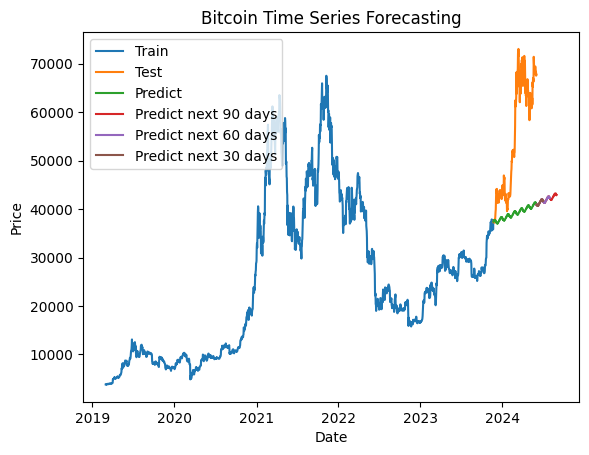

In [216]:
sns.lineplot(data=train_data, x=train_data.index, y=train_data['Price'],label='Train')
sns.lineplot(data=test_data, x=test_data.index, y=test_data['Price'],label='Test')
sns.lineplot(data=test_data, x=test_data.index, y=test_prediction,label='Predict')
sns.lineplot(data=future_prediction_df[-90:], x=future_index[:90], y=future_prediction_df['Price'][-90:],label='Predict next 90 days')
sns.lineplot(data=next60days_df, x=next60days_index, y=next60days_df['Price'],label='Predict next 60 days')
sns.lineplot(data=next30days_df, x=next30days_index, y=next30days_df['Price'],label='Predict next 30 days')
plt.title('Bitcoin Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')

# 8. ETH/USD Dataset (Data split 9:1)

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [219]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df.set_index('Date',inplace=True)
df = df[['Price']]

In [220]:
train_size = int(0.9 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size:]

In [221]:
from statsmodels.tsa.stattools import adfuller

In [222]:
def test_stationarity(variable):
    result=adfuller(variable)
    labels = ['t-statistics', 'p-value', 'lags_used', 'number of observations used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [223]:
test_stationarity(train_data['Price'])

t-statistics : -1.54829210694358
p-value : 0.5095011982270166
lags_used : 17
number of observations used : 1710
Data is non-stationary 


<Axes: xlabel='Date', ylabel='Price'>

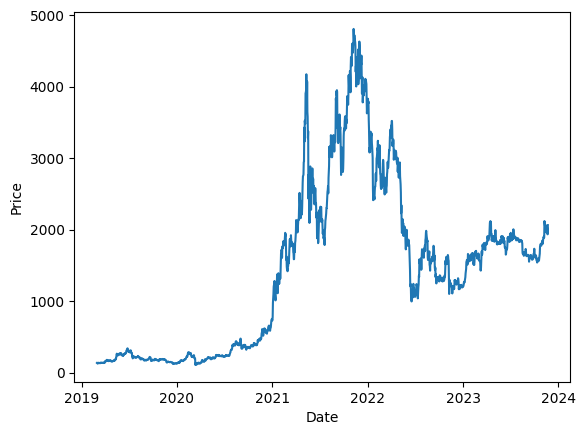

In [224]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Price'])

In [225]:
train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\220069074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)


In [226]:
train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\2698099252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)


In [227]:
test_stationarity(train_data['First Difference'].dropna())

t-statistics : -10.396333420706814
p-value : 1.960852477601676e-18
lags_used : 16
number of observations used : 1710
Data is stationary


<Axes: xlabel='Date', ylabel='First Difference'>

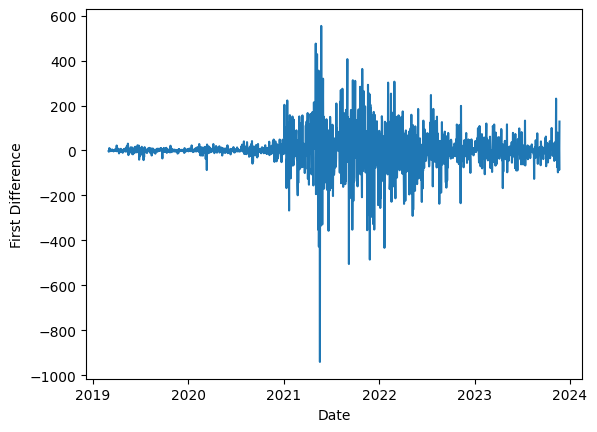

In [228]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['First Difference'])

In [229]:
test_stationarity(train_data['Seasonal First Difference'].dropna())

t-statistics : -7.20659005994099
p-value : 2.2917420737464393e-10
lags_used : 25
number of observations used : 1672
Data is stationary


<Axes: xlabel='Date', ylabel='Seasonal First Difference'>

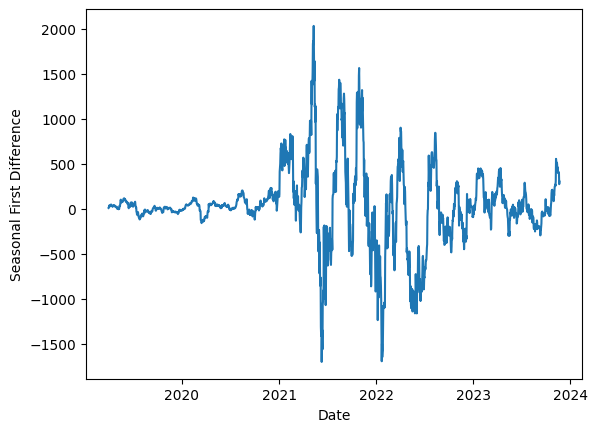

In [230]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Seasonal First Difference'])

In [231]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

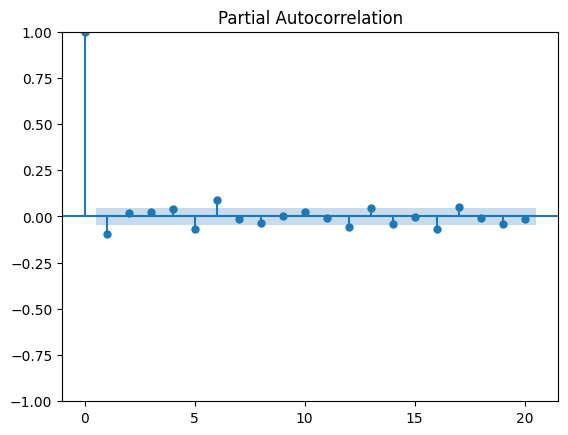

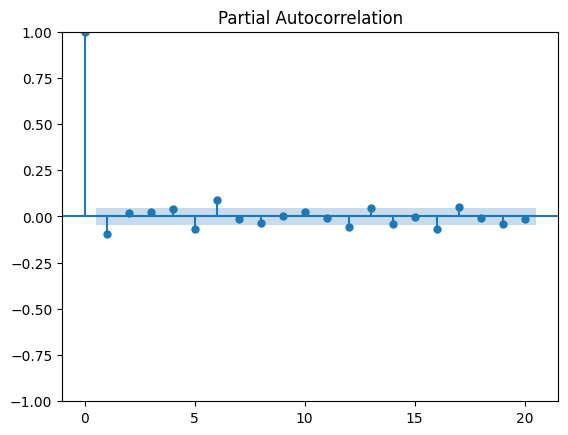

In [232]:
plot_pacf(train_data['First Difference'].dropna(),lags=20)

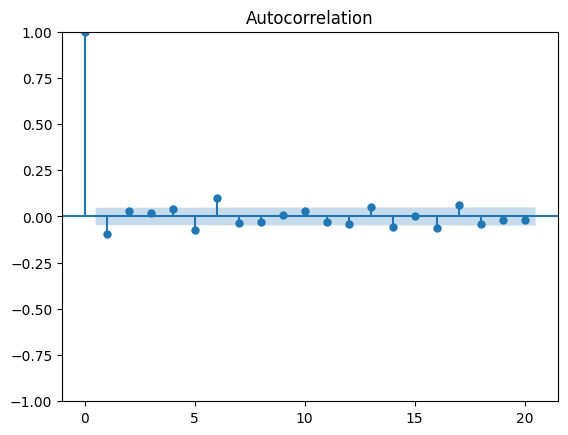

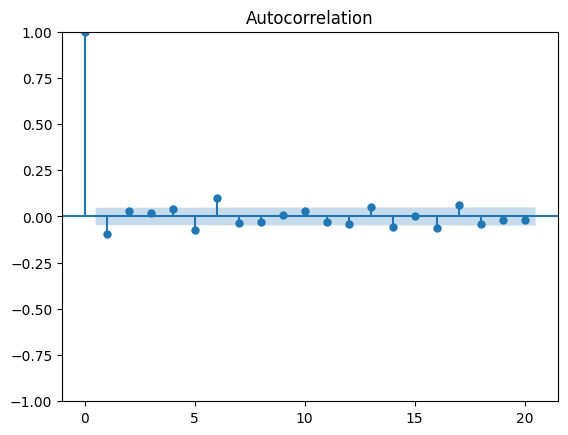

In [233]:
plot_acf(train_data['First Difference'].dropna(),lags=20)

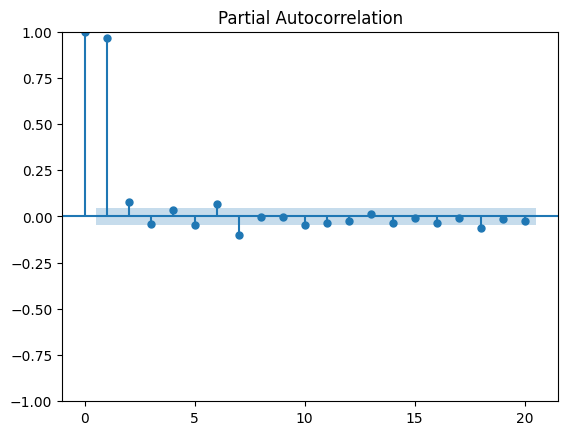

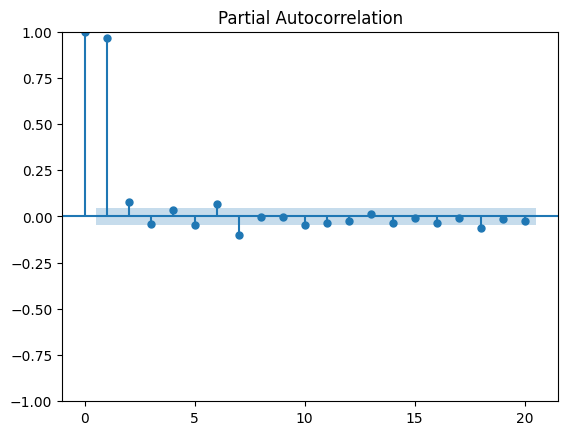

In [234]:
plot_pacf(train_data['Seasonal First Difference'].dropna(),lags=20)

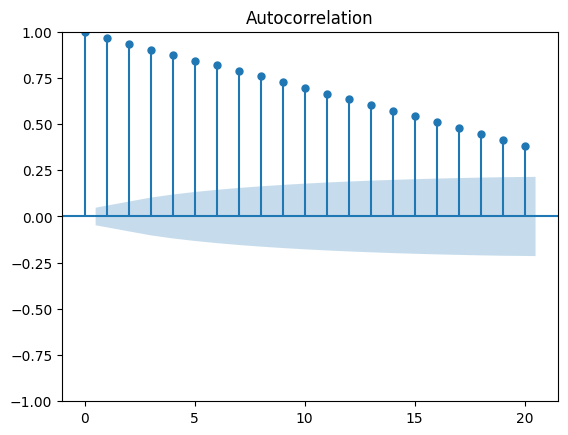

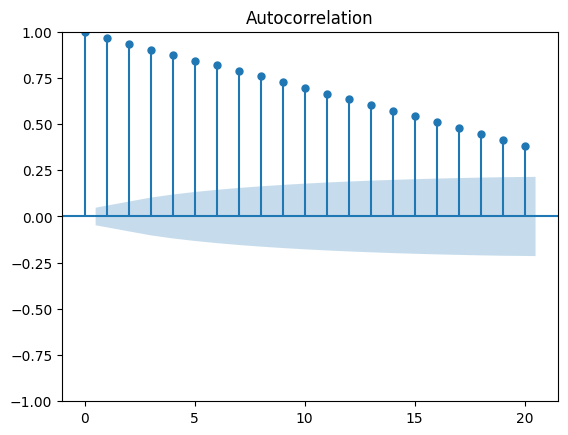

In [235]:
plot_acf(train_data['Seasonal First Difference'].dropna(),lags=20)

In [236]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [237]:
model = SARIMAX (train_data['Price'], order = (1,1,1), seasonal_order = (1,1,1,30))
model_fit = model.fit()

C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [238]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 1728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -9972.488
Date:                            Wed, 05 Jun 2024   AIC                          19954.976
Time:                                    10:01:50   BIC                          19982.159
Sample:                                03-01-2019   HQIC                         19965.040
                                     - 11-22-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2437      0.120     -2.023      0.043      -0.480      -0.008
ma.L1          0.1460      0.124      1.176      0.240      -0.097       0.389
ar.S.L30       0.0381      0.017      2.223      0.026       0.005       0.072
ma.S.L30      -0.9992      0.482     -2.073      0.038      -1.944      -0.054
sigma2      6945.8321   3312.169      2.097      0.036     454.100    1.34e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15616.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              29.53   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [239]:
test_prediction = model_fit.forecast(steps=len(test_data))
frame = {'Price':test_prediction[0:]}
test_prediction_df = pd.DataFrame(frame)

In [240]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test = np.array(test_data['Price'])
y_pred = np.array(test_prediction_df['Price'])

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 24.066779603155826
RMSE: 938.3500550085038
MAE: 773.1659778490192


In [241]:
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90)

In [242]:
future_prediction = model_fit.forecast(steps=len(test_data)+90)
frame = {'Price':future_prediction[0:]}
future_prediction_df = pd.DataFrame(frame)

In [243]:
next60days_df = future_prediction_df[-90:]
next60days_df = next60days_df[:60]
next60days_index = future_index[-90:]
next60days_index = next60days_index[:60]

next30days_df = future_prediction_df[-90:]
next30days_df = next30days_df[:30]
next30days_index = future_index[-90:]
next30days_index = next30days_index[:30]

Text(0, 0.5, 'Price')

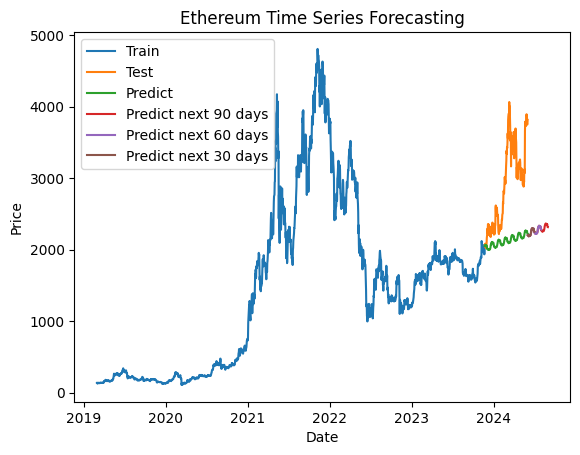

In [245]:
sns.lineplot(data=train_data, x=train_data.index, y=train_data['Price'],label='Train')
sns.lineplot(data=test_data, x=test_data.index, y=test_data['Price'],label='Test')
sns.lineplot(data=test_data, x=test_data.index, y=test_prediction,label='Predict')
sns.lineplot(data=future_prediction_df[-90:], x=future_index[:90], y=future_prediction_df['Price'][-90:],label='Predict next 90 days')
sns.lineplot(data=next60days_df, x=next60days_index, y=next60days_df['Price'],label='Predict next 60 days')
sns.lineplot(data=next30days_df, x=next30days_index, y=next30days_df['Price'],label='Predict next 30 days')
plt.title('Ethereum Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')

# 9. BNB/USD Dataset (Data split 9:1)

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [248]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [249]:
train_size = int(0.9 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size:]

In [250]:
from statsmodels.tsa.stattools import adfuller

In [251]:
def test_stationarity(variable):
    result=adfuller(variable)
    labels = ['t-statistics', 'p-value', 'lags_used', 'number of observations used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [252]:
test_stationarity(train_data['Price'])

t-statistics : -1.8281963679479987
p-value : 0.3665555354715905
lags_used : 25
number of observations used : 1702
Data is non-stationary 


<Axes: xlabel='Date', ylabel='Price'>

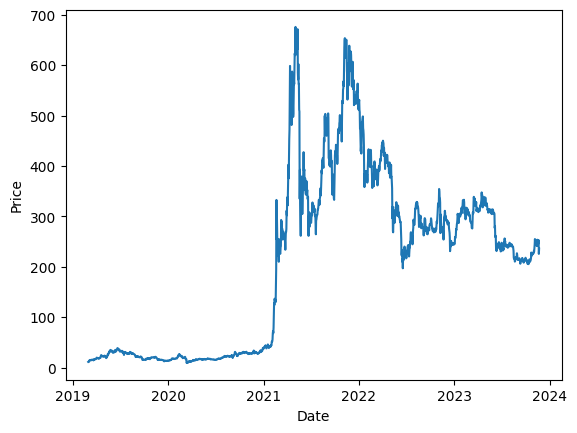

In [253]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Price'])

In [254]:
train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\220069074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['First Difference'] = train_data['Price'] - train_data['Price'].shift(1)


In [255]:
train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14308\2698099252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Seasonal First Difference'] = train_data['Price']-train_data['Price'].shift(30)


In [256]:
test_stationarity(train_data['First Difference'].dropna())

t-statistics : -7.750700320464524
p-value : 1.0038502521783725e-11
lags_used : 24
number of observations used : 1702
Data is stationary


<Axes: xlabel='Date', ylabel='First Difference'>

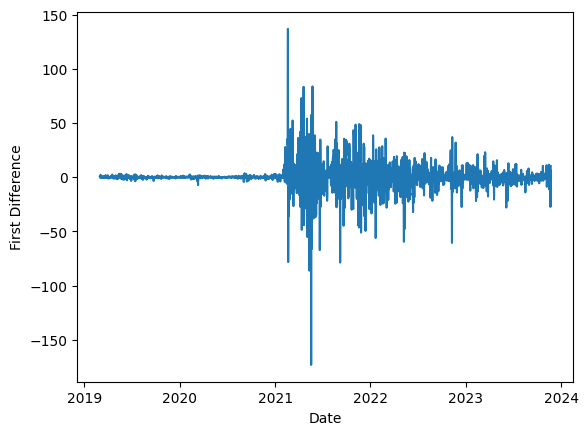

In [257]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['First Difference'])

In [259]:
test_stationarity(train_data['Seasonal First Difference'].dropna())

t-statistics : -7.417499053062929
p-value : 6.873667016029648e-11
lags_used : 25
number of observations used : 1672
Data is stationary


<Axes: xlabel='Date', ylabel='Seasonal First Difference'>

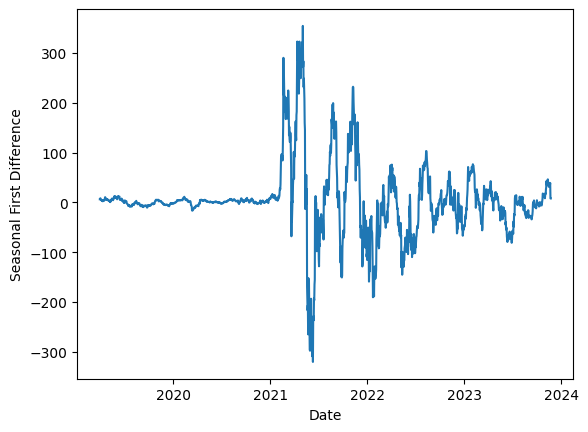

In [260]:
sns.lineplot(data = train_data, x = train_data.index, y = train_data['Seasonal First Difference'])

In [261]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

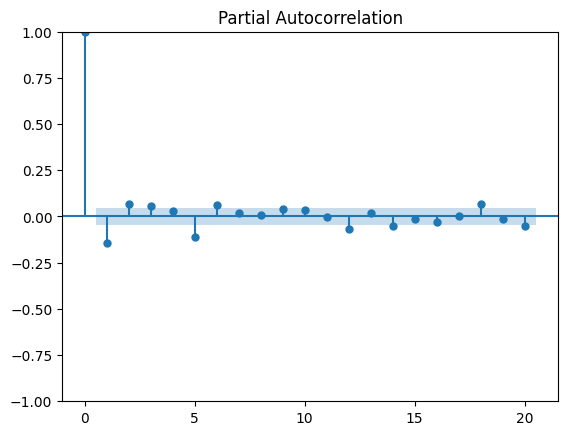

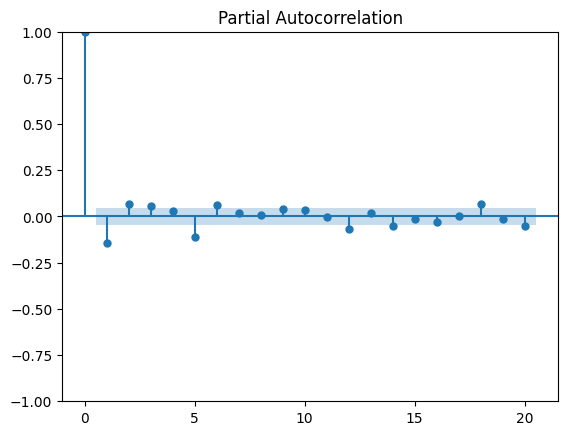

In [262]:
plot_pacf(train_data['First Difference'].dropna(),lags=20)

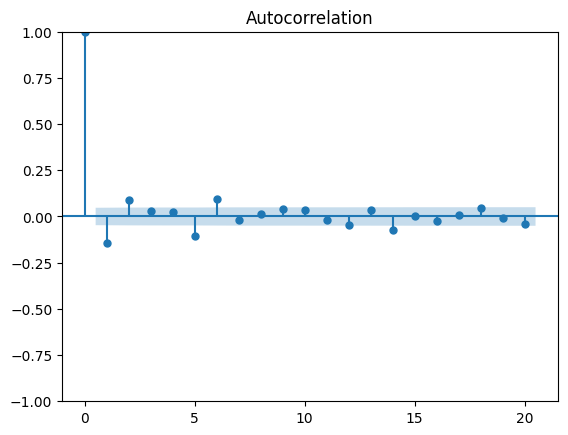

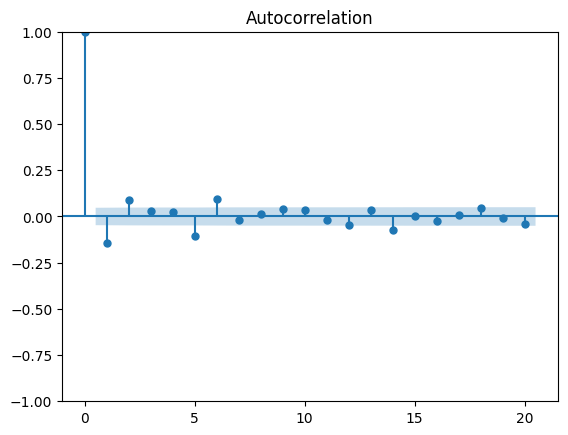

In [263]:
plot_acf(train_data['First Difference'].dropna(),lags=20)

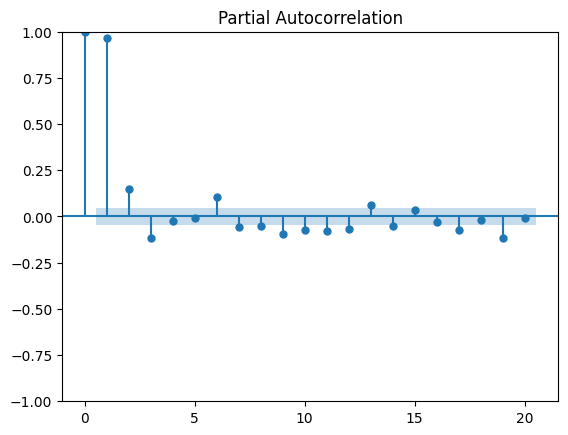

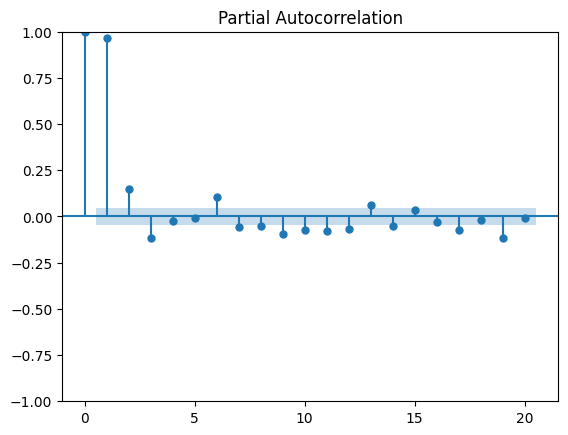

In [264]:
plot_pacf(train_data['Seasonal First Difference'].dropna(),lags=20)

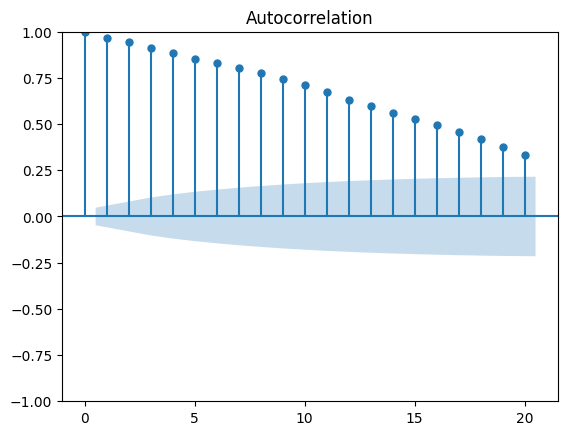

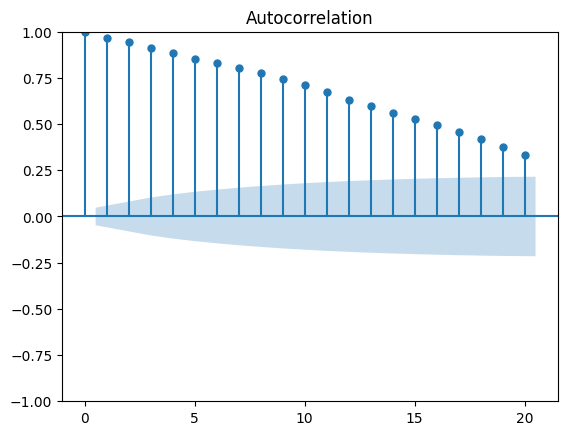

In [265]:
plot_acf(train_data['Seasonal First Difference'].dropna(),lags=20)

In [266]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [267]:
model = SARIMAX (train_data['Price'], order = (1,1,1), seasonal_order = (1,1,1,30))
model_fit = model.fit()

C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [268]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 1728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -6853.906
Date:                            Wed, 05 Jun 2024   AIC                          13717.812
Time:                                    10:07:17   BIC                          13744.995
Sample:                                03-01-2019   HQIC                         13727.876
                                     - 11-22-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4973      0.060     -8.233      0.000      -0.616      -0.379
ma.L1          0.3572      0.065      5.477      0.000       0.229       0.485
ar.S.L30       0.0425      0.017      2.573      0.010       0.010       0.075
ma.S.L30      -0.9999      2.963     -0.337      0.736      -6.807       4.807
sigma2       175.8634    519.955      0.338      0.735    -843.230    1194.956
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             59287.98
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              77.33   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [269]:
test_prediction = model_fit.forecast(steps=len(test_data))
frame = {'Price':test_prediction[0:]}
test_prediction_df = pd.DataFrame(frame)

In [270]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test = np.array(test_data['Price'])
y_pred = np.array(test_prediction_df['Price'])

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 36.82670838612485
RMSE: 230.67084565095772
MAE: 186.2406697858817


In [271]:
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90)

In [272]:
future_prediction = model_fit.forecast(steps=len(test_data)+90)
frame = {'Price':future_prediction[0:]}
future_prediction_df = pd.DataFrame(frame)

In [273]:
next60days_df = future_prediction_df[-90:]
next60days_df = next60days_df[:60]
next60days_index = future_index[-90:]
next60days_index = next60days_index[:60]

next30days_df = future_prediction_df[-90:]
next30days_df = next30days_df[:30]
next30days_index = future_index[-90:]
next30days_index = next30days_index[:30]

Text(0, 0.5, 'Price')

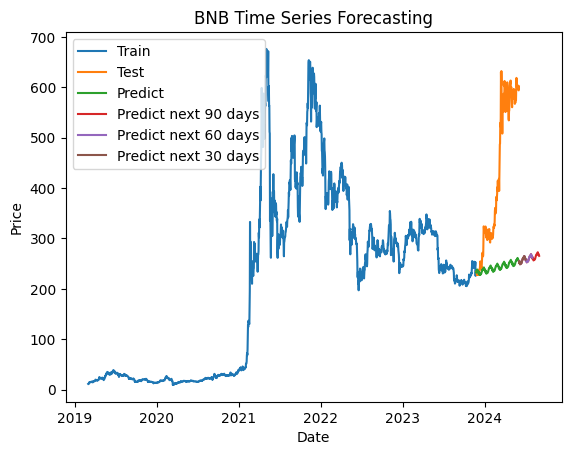

In [274]:
sns.lineplot(data=train_data, x=train_data.index, y=train_data['Price'],label='Train')
sns.lineplot(data=test_data, x=test_data.index, y=test_data['Price'],label='Test')
sns.lineplot(data=test_data, x=test_data.index, y=test_prediction,label='Predict')
sns.lineplot(data=future_prediction_df[-90:], x=future_index[:90], y=future_prediction_df['Price'][-90:],label='Predict next 90 days')
sns.lineplot(data=next60days_df, x=next60days_index, y=next60days_df['Price'],label='Predict next 60 days')
sns.lineplot(data=next30days_df, x=next30days_index, y=next30days_df['Price'],label='Predict next 30 days')
plt.title('BNB Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')